In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-07-06 12:33:28.028809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:33:28.243749: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:33:28.971592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-07-06 12:33:28.971641: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12286
12286
12286
12286
12286
12286
12286
12286


In [7]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 10000
num_data = 5000


In [8]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  168

X_mon1_train :  (4999, 168)
y_mon1_train :  (4999,)
X_mon1_val :  (1667, 168)
y_mon1_val :  (1667,)
X_mon1_test :  (3334, 168)
y_mon1_test :  (3334,)



In [9]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  1799

X_mon2_train :  (4999, 1799)
y_mon2_train :  (4999,)
X_mon2_val :  (1667, 1799)
y_mon2_val :  (1667,)
X_mon2_test :  (3334, 1799)
y_mon2_test :  (3334,)



In [10]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot_img/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot_img/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
#X_mon3 = scaler.fit_transform(X_mon3)
X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (4999, 128, 128, 1)
y_mon3_train :  (4999,)
X_mon3_val :  (1667, 128, 128, 1)
y_mon3_val :  (1667,)
X_mon3_test :  (3334, 128, 128, 1)
y_mon3_test :  (3334,)



In [11]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top_img/ev_1'] )
hits_top_S = np.array( f_S['HITS_top_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top_img/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top_img/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B,hits_top_S])
# normalize
#X_mon4 = scaler.fit_transform(X_mon4)
X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (4999, 128, 128, 1)
y_mon4_train :  (4999,)
X_mon4_val :  (1667, 128, 128, 1)
y_mon4_val :  (1667,)
X_mon4_test :  (3334, 128, 128, 1)
y_mon4_test :  (3334,)



In [12]:
# close the h5 files
f_B.close()
f_S.close()

In [13]:
X_mon1_val_SM = []
X_mon1_val_NP = []

for i in range(len(y_mon1_val)):
    if y_mon1_val[i] == 0:
        X_mon1_val_SM.append( X_mon1_val[i].tolist() )
    else:
        X_mon1_val_NP.append( X_mon1_val[i].tolist() )

        
X_mon2_val_SM = []
X_mon2_val_NP = []

for i in range(len(y_mon2_val)):
    if y_mon2_val[i] == 0:
        X_mon2_val_SM.append( X_mon2_val[i].tolist() )
    else:
        X_mon2_val_NP.append( X_mon2_val[i].tolist() )  
        
        
X_mon3_val_SM = []
X_mon3_val_NP = []

for i in range(len(y_mon3_val)):
    if y_mon3_val[i] == 0:
        X_mon3_val_SM.append( X_mon3_val[i].tolist() )
    else:
        X_mon3_val_NP.append( X_mon3_val[i].tolist() )

        
X_mon4_val_SM = []
X_mon4_val_NP = []

for i in range(len(y_mon4_val)):
    if y_mon4_val[i] == 0:
        X_mon4_val_SM.append( X_mon4_val[i].tolist() )
    else:
        X_mon4_val_NP.append( X_mon4_val[i].tolist() )    

In [14]:
len(X_mon3_val_SM[0])

128

In [15]:
X_mon1_val_SM = np.asarray(X_mon1_val_SM)
X_mon2_val_SM = np.asarray(X_mon2_val_SM)
X_mon3_val_SM = np.asarray(X_mon3_val_SM)
X_mon4_val_SM = np.asarray(X_mon4_val_SM)

In [16]:
X_mon1_val_NP = np.asarray(X_mon1_val_NP)
X_mon2_val_NP = np.asarray(X_mon2_val_NP)
X_mon3_val_NP = np.asarray(X_mon3_val_NP)
X_mon4_val_NP = np.asarray(X_mon4_val_NP)

### CLASSIFIER

In [20]:
from keras.layers import concatenate
from tensorflow.keras.models import Model

#### 1 conv layer per block (final dense 32-16-1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 168, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2244, 1)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                           

 dropout_7 (Dropout)            (None, 16)           0           ['leaky_re_lu_7[0][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 64)           0           ['dropout_1[0][0]',              
                                                                  'dropout_3[0][0]',              
                                                                  'dropout_5[0][0]',              
                                                                  'dropout_7[0][0]']              
                                                                                                  
 dense_4 (Dense)                (None, 32)           2080        ['concatenate[0][0]']            
                                                                                                  
 dropout_8 (Dropout)            (None, 32)           0           ['dense_4[0][0]']                
          

2023-05-19 17:26:19.733360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-19 17:26:19.733376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pcmadrid): /proc/driver/nvidia/version does not exist
2023-05-19 17:26:19.734052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1500
79/79 [==============================] - 29s 349ms/step - loss: 0.9682 - accuracy: 0.6182 - val_loss: 0.5531 - val_accuracy: 0.8269
Epoch 2/1500
79/79 [==============================] - 27s 345ms/step - loss: 0.5777 - accuracy: 0.7818 - val_loss: 0.4776 - val_accuracy: 0.8368
Epoch 3/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.5086 - accuracy: 0.8106 - val_loss: 0.4490 - val_accuracy: 0.8479
Epoch 4/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.4684 - accuracy: 0.8231 - val_loss: 0.4154 - val_accuracy: 0.8494
Epoch 5/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.4554 - accuracy: 0.8223 - val_loss: 0.3993 - val_accuracy: 0.8491
Epoch 6/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.4496 - accuracy: 0.8292 - val_loss: 0.3932 - val_accuracy: 0.8515
Epoch 7/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.4351 - accuracy: 0.8344 - val_loss: 0.4054 - val_ac

79/79 [==============================] - 27s 346ms/step - loss: 0.3538 - accuracy: 0.8643 - val_loss: 0.3361 - val_accuracy: 0.8674
Epoch 114/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3580 - accuracy: 0.8614 - val_loss: 0.3542 - val_accuracy: 0.8746
Epoch 115/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3803 - accuracy: 0.8589 - val_loss: 0.3566 - val_accuracy: 0.8650
Epoch 116/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3753 - accuracy: 0.8570 - val_loss: 0.3607 - val_accuracy: 0.8674
Epoch 117/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3550 - accuracy: 0.8630 - val_loss: 0.3420 - val_accuracy: 0.8725
Epoch 118/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3508 - accuracy: 0.8649 - val_loss: 0.3587 - val_accuracy: 0.8572
Epoch 119/1500
79/79 [==============================] - 27s 345ms/step - loss: 0.3521 - accuracy: 0.8612 - val_loss: 0.3240 - val_acc

Epoch 169/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3627 - accuracy: 0.8632 - val_loss: 0.3458 - val_accuracy: 0.8686
Epoch 170/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3550 - accuracy: 0.8614 - val_loss: 0.3549 - val_accuracy: 0.8638
Epoch 171/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3453 - accuracy: 0.8632 - val_loss: 0.3472 - val_accuracy: 0.8650
Epoch 172/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3467 - accuracy: 0.8651 - val_loss: 0.3458 - val_accuracy: 0.8650
Epoch 173/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3440 - accuracy: 0.8622 - val_loss: 0.3503 - val_accuracy: 0.8626
Epoch 174/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3434 - accuracy: 0.8667 - val_loss: 0.3270 - val_accuracy: 0.8731
Epoch 175/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3488 - accuracy: 0.8629 - val_loss: 0

Epoch 225/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3513 - accuracy: 0.8605 - val_loss: 0.3582 - val_accuracy: 0.8575
Epoch 226/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3473 - accuracy: 0.8634 - val_loss: 0.3354 - val_accuracy: 0.8683
Epoch 227/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3487 - accuracy: 0.8642 - val_loss: 0.3432 - val_accuracy: 0.8638
Epoch 228/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3442 - accuracy: 0.8648 - val_loss: 0.3559 - val_accuracy: 0.8605
Epoch 229/1500
79/79 [==============================] - 27s 347ms/step - loss: 0.3440 - accuracy: 0.8680 - val_loss: 0.3327 - val_accuracy: 0.8770
Epoch 230/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3473 - accuracy: 0.8647 - val_loss: 0.3597 - val_accuracy: 0.8572
Epoch 231/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3536 - accuracy: 0.8618 - val_loss: 0

Epoch 281/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3408 - accuracy: 0.8701 - val_loss: 0.3377 - val_accuracy: 0.8629
Epoch 282/1500
79/79 [==============================] - 28s 357ms/step - loss: 0.3368 - accuracy: 0.8714 - val_loss: 0.3572 - val_accuracy: 0.8590
Epoch 283/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3361 - accuracy: 0.8701 - val_loss: 0.3978 - val_accuracy: 0.8383
Epoch 284/1500
79/79 [==============================] - 27s 347ms/step - loss: 0.3467 - accuracy: 0.8654 - val_loss: 0.3627 - val_accuracy: 0.8557
Epoch 285/1500
79/79 [==============================] - 28s 350ms/step - loss: 0.3523 - accuracy: 0.8642 - val_loss: 0.3329 - val_accuracy: 0.8677
Epoch 286/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3401 - accuracy: 0.8708 - val_loss: 0.3542 - val_accuracy: 0.8602
Epoch 287/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3371 - accuracy: 0.8684 - val_loss: 0

Epoch 337/1500
79/79 [==============================] - 28s 349ms/step - loss: 0.3559 - accuracy: 0.8686 - val_loss: 0.3558 - val_accuracy: 0.8665
Epoch 338/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3661 - accuracy: 0.8664 - val_loss: 0.3549 - val_accuracy: 0.8680
Epoch 339/1500
79/79 [==============================] - 28s 360ms/step - loss: 0.3528 - accuracy: 0.8678 - val_loss: 0.3488 - val_accuracy: 0.8635
Epoch 340/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3585 - accuracy: 0.8674 - val_loss: 0.3697 - val_accuracy: 0.8581
Epoch 341/1500
79/79 [==============================] - 28s 359ms/step - loss: 0.3523 - accuracy: 0.8665 - val_loss: 0.3466 - val_accuracy: 0.8719
Epoch 342/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3487 - accuracy: 0.8666 - val_loss: 0.3628 - val_accuracy: 0.8617
Epoch 343/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3496 - accuracy: 0.8664 - val_loss: 0

Epoch 393/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3437 - accuracy: 0.8644 - val_loss: 0.3667 - val_accuracy: 0.8521
Epoch 394/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3451 - accuracy: 0.8650 - val_loss: 0.3508 - val_accuracy: 0.8629
Epoch 395/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3454 - accuracy: 0.8672 - val_loss: 0.3507 - val_accuracy: 0.8638
Epoch 396/1500
79/79 [==============================] - 27s 345ms/step - loss: 0.3471 - accuracy: 0.8646 - val_loss: 0.4007 - val_accuracy: 0.8359
Epoch 397/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3440 - accuracy: 0.8708 - val_loss: 0.3649 - val_accuracy: 0.8572
Epoch 398/1500
79/79 [==============================] - 27s 346ms/step - loss: 0.3394 - accuracy: 0.8696 - val_loss: 0.3571 - val_accuracy: 0.8581
Epoch 399/1500
79/79 [==============================] - 28s 356ms/step - loss: 0.3514 - accuracy: 0.8693 - val_loss: 0

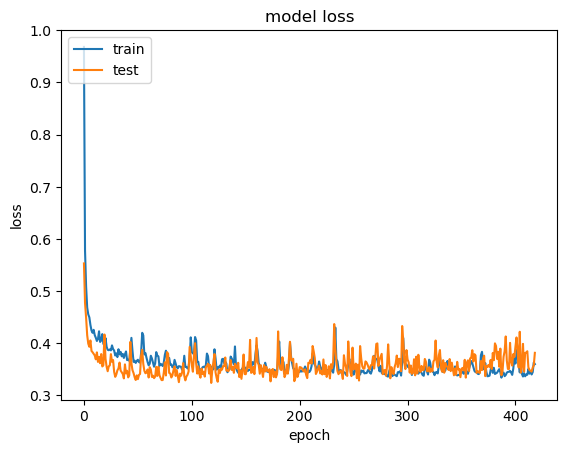

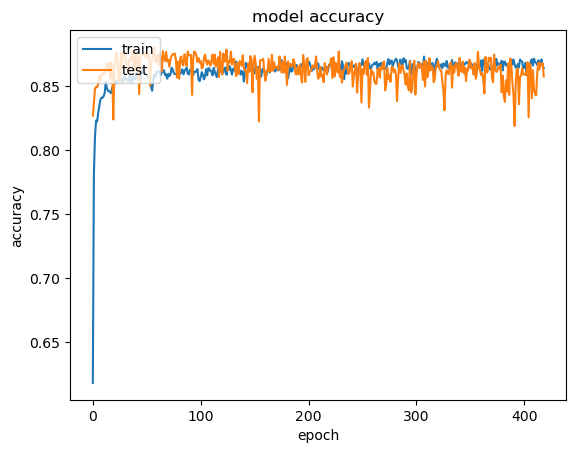

209/209 [==============================] - 4s 17ms/step


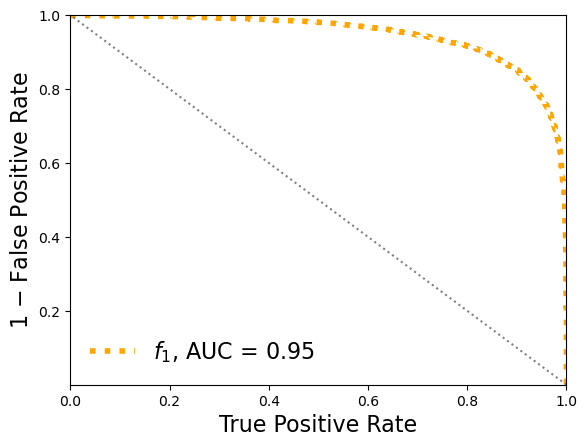

In [14]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top])


# Dense layers
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [15]:
roc_auc_conv

0.946066702844847

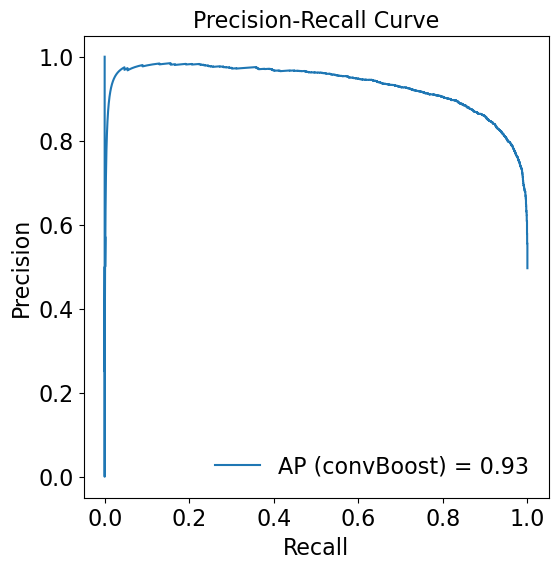

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_conv, recall_conv, _ = precision_recall_curve(y_mon1_test, y_pred_conv)
auc_conv = auc(recall_conv, precision_conv)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_conv, precision_conv, label=f'AP (convBoost) = {auc_conv:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [17]:
auc_conv

0.9326900805687894

Classification score:


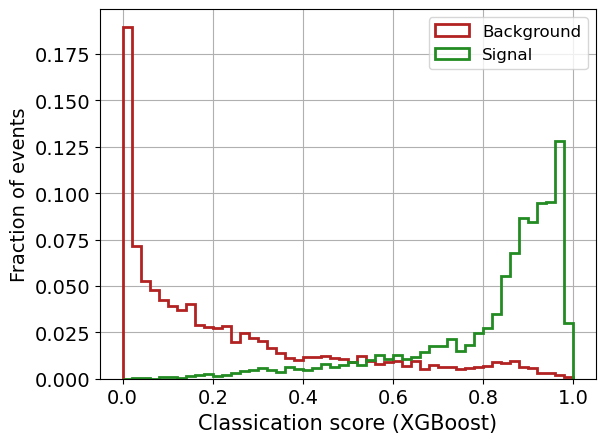

In [18]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 2 conv layer per block (final dense 64-32-16-1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 168, 1)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2244, 1)]    0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                         

 flatten_4 (Flatten)            (None, 2592)         0           ['dropout_10[0][0]']             
                                                                                                  
 flatten_5 (Flatten)            (None, 35808)        0           ['dropout_12[0][0]']             
                                                                                                  
 flatten_6 (Flatten)            (None, 238144)       0           ['dropout_14[0][0]']             
                                                                                                  
 flatten_7 (Flatten)            (None, 238144)       0           ['dropout_16[0][0]']             
                                                                                                  
 dense_7 (Dense)                (None, 16)           41488       ['flatten_4[0][0]']              
                                                                                                  
 dense_8 (

Epoch 21/1500
79/79 [==============================] - 41s 522ms/step - loss: 0.4055 - accuracy: 0.8276 - val_loss: 0.3733 - val_accuracy: 0.8497
Epoch 22/1500
79/79 [==============================] - 41s 525ms/step - loss: 0.4097 - accuracy: 0.8291 - val_loss: 0.3763 - val_accuracy: 0.8452
Epoch 23/1500
79/79 [==============================] - 42s 532ms/step - loss: 0.4045 - accuracy: 0.8304 - val_loss: 0.3747 - val_accuracy: 0.8527
Epoch 24/1500
79/79 [==============================] - 42s 528ms/step - loss: 0.3945 - accuracy: 0.8318 - val_loss: 0.3699 - val_accuracy: 0.8470
Epoch 25/1500
79/79 [==============================] - 41s 524ms/step - loss: 0.4072 - accuracy: 0.8292 - val_loss: 0.3722 - val_accuracy: 0.8482
Epoch 26/1500
79/79 [==============================] - 42s 528ms/step - loss: 0.3991 - accuracy: 0.8304 - val_loss: 0.3761 - val_accuracy: 0.8428
Epoch 27/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.4020 - accuracy: 0.8339 - val_loss: 0.3731 -

Epoch 133/1500
79/79 [==============================] - 42s 533ms/step - loss: 0.3889 - accuracy: 0.8344 - val_loss: 0.4398 - val_accuracy: 0.8176
Epoch 134/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.3866 - accuracy: 0.8291 - val_loss: 0.4136 - val_accuracy: 0.8251
Epoch 135/1500
79/79 [==============================] - 41s 522ms/step - loss: 0.3804 - accuracy: 0.8313 - val_loss: 0.3977 - val_accuracy: 0.8404
Epoch 136/1500
79/79 [==============================] - 41s 525ms/step - loss: 0.3820 - accuracy: 0.8314 - val_loss: 0.4152 - val_accuracy: 0.8332
Epoch 137/1500
79/79 [==============================] - 41s 525ms/step - loss: 0.3809 - accuracy: 0.8344 - val_loss: 0.4433 - val_accuracy: 0.8059
Epoch 138/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.3827 - accuracy: 0.8357 - val_loss: 0.4214 - val_accuracy: 0.8218
Epoch 139/1500
79/79 [==============================] - 42s 530ms/step - loss: 0.3934 - accuracy: 0.8304 - val_loss: 0

Epoch 189/1500
79/79 [==============================] - 42s 530ms/step - loss: 0.3851 - accuracy: 0.8305 - val_loss: 0.4461 - val_accuracy: 0.8101
Epoch 190/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.3817 - accuracy: 0.8359 - val_loss: 0.4234 - val_accuracy: 0.8152
Epoch 191/1500
79/79 [==============================] - 42s 531ms/step - loss: 0.3818 - accuracy: 0.8353 - val_loss: 0.4153 - val_accuracy: 0.8305
Epoch 192/1500
79/79 [==============================] - 42s 536ms/step - loss: 0.3814 - accuracy: 0.8333 - val_loss: 0.4220 - val_accuracy: 0.8170
Epoch 193/1500
79/79 [==============================] - 41s 524ms/step - loss: 0.3817 - accuracy: 0.8334 - val_loss: 0.4196 - val_accuracy: 0.8275
Epoch 194/1500
79/79 [==============================] - 41s 526ms/step - loss: 0.3779 - accuracy: 0.8361 - val_loss: 0.4260 - val_accuracy: 0.8227
Epoch 195/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.3885 - accuracy: 0.8321 - val_loss: 0

Epoch 245/1500
79/79 [==============================] - 41s 522ms/step - loss: 0.3910 - accuracy: 0.8327 - val_loss: 0.4135 - val_accuracy: 0.8410
Epoch 246/1500
79/79 [==============================] - 41s 524ms/step - loss: 0.3886 - accuracy: 0.8338 - val_loss: 0.4078 - val_accuracy: 0.8431
Epoch 247/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.3909 - accuracy: 0.8317 - val_loss: 0.4252 - val_accuracy: 0.8287
Epoch 248/1500
79/79 [==============================] - 42s 531ms/step - loss: 0.3860 - accuracy: 0.8338 - val_loss: 0.3959 - val_accuracy: 0.8407
Epoch 249/1500
79/79 [==============================] - 42s 527ms/step - loss: 0.3934 - accuracy: 0.8302 - val_loss: 0.4424 - val_accuracy: 0.8092
Epoch 250/1500
79/79 [==============================] - 41s 522ms/step - loss: 0.3894 - accuracy: 0.8330 - val_loss: 0.4533 - val_accuracy: 0.7981
Epoch 251/1500
79/79 [==============================] - 42s 526ms/step - loss: 0.3839 - accuracy: 0.8338 - val_loss: 0

Epoch 301/1500
79/79 [==============================] - 41s 525ms/step - loss: 0.3823 - accuracy: 0.8301 - val_loss: 0.4110 - val_accuracy: 0.8389
Epoch 302/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.3889 - accuracy: 0.8320 - val_loss: 0.4265 - val_accuracy: 0.8392
Epoch 303/1500
79/79 [==============================] - 41s 521ms/step - loss: 0.3805 - accuracy: 0.8335 - val_loss: 0.4106 - val_accuracy: 0.8383
Epoch 304/1500
79/79 [==============================] - 42s 532ms/step - loss: 0.3816 - accuracy: 0.8325 - val_loss: 0.4152 - val_accuracy: 0.8344
Epoch 305/1500
79/79 [==============================] - 42s 527ms/step - loss: 0.3798 - accuracy: 0.8357 - val_loss: 0.4208 - val_accuracy: 0.8377
Epoch 306/1500
79/79 [==============================] - 42s 529ms/step - loss: 0.3798 - accuracy: 0.8329 - val_loss: 0.4265 - val_accuracy: 0.8350
Epoch 307/1500
79/79 [==============================] - 42s 531ms/step - loss: 0.3824 - accuracy: 0.8311 - val_loss: 0

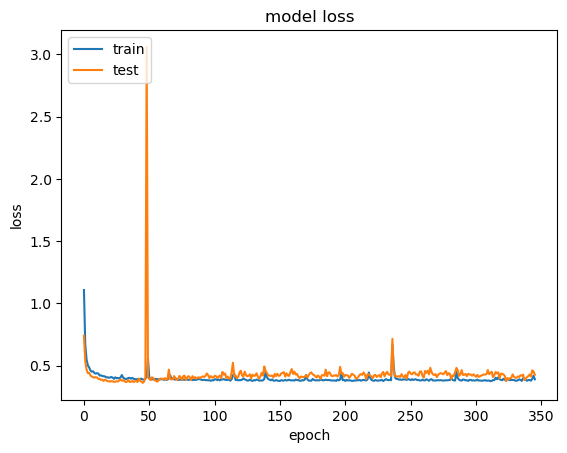

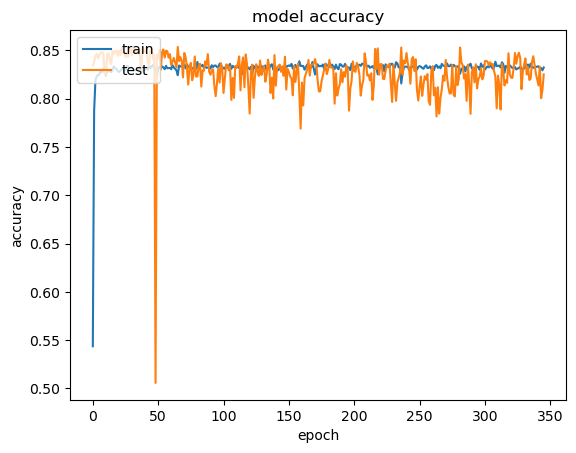

209/209 [==============================] - 6s 29ms/step


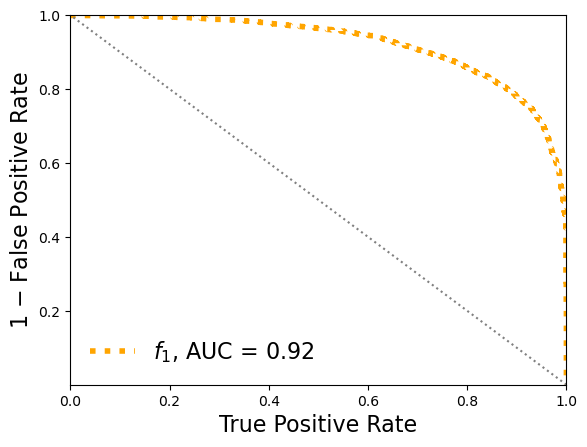

In [19]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [20]:
roc_auc_conv

0.9210728900336314

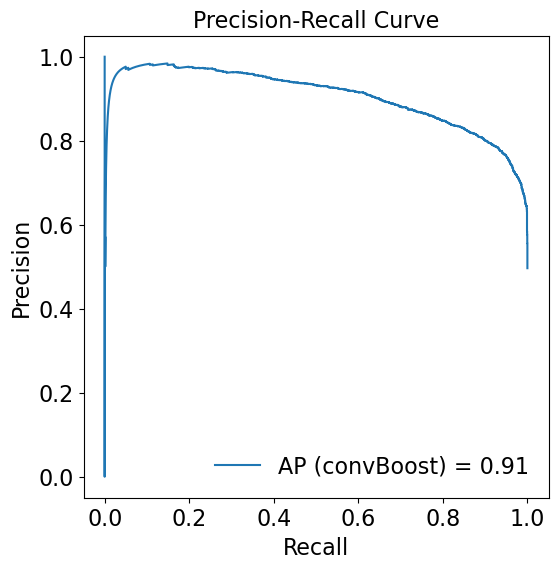

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_conv, recall_conv, _ = precision_recall_curve(y_mon1_test, y_pred_conv)
auc_conv = auc(recall_conv, precision_conv)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_conv, precision_conv, label=f'AP (convBoost) = {auc_conv:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [22]:
auc_conv

0.9054679324291683

Classification score:


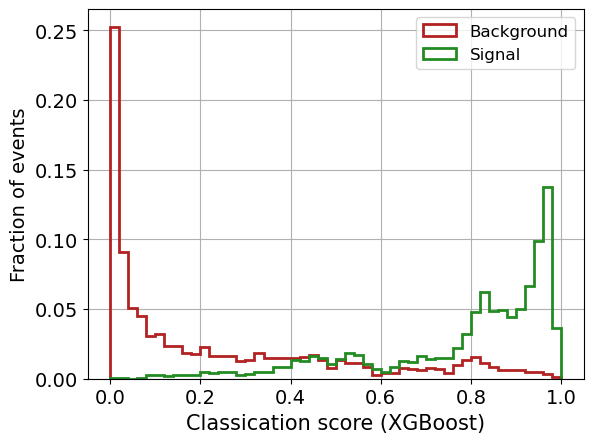

In [23]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 1 conv layer (peakS1 and Hits_bot) , 2 conv layer (peakS2 and Hits_top)  (final dense 64-32-16-1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 2244, 1)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 2242, 16)     64          ['input_10[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 126, 126, 16  160         ['input_12[0][0]']         

                                                                                                  
 leaky_re_lu_21 (LeakyReLU)     (None, 16)           0           ['dense_15[0][0]']               
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)     (None, 16)           0           ['dense_16[0][0]']               
                                                                                                  
 leaky_re_lu_26 (LeakyReLU)     (None, 16)           0           ['dense_17[0][0]']               
                                                                                                  
 leaky_re_lu_29 (LeakyReLU)     (None, 16)           0           ['dense_18[0][0]']               
                                                                                                  
 dropout_22 (Dropout)           (None, 16)           0           ['leaky_re_lu_21[0][0]']         
          

Epoch 31/1500
79/79 [==============================] - 35s 449ms/step - loss: 0.3957 - accuracy: 0.8536 - val_loss: 0.3489 - val_accuracy: 0.8692
Epoch 32/1500
79/79 [==============================] - 36s 454ms/step - loss: 0.4542 - accuracy: 0.8412 - val_loss: 0.3737 - val_accuracy: 0.8680
Epoch 33/1500
79/79 [==============================] - 35s 449ms/step - loss: 0.3890 - accuracy: 0.8560 - val_loss: 0.3699 - val_accuracy: 0.8473
Epoch 34/1500
79/79 [==============================] - 35s 447ms/step - loss: 0.3862 - accuracy: 0.8519 - val_loss: 0.3404 - val_accuracy: 0.8728
Epoch 35/1500
79/79 [==============================] - 36s 461ms/step - loss: 0.3799 - accuracy: 0.8558 - val_loss: 0.3474 - val_accuracy: 0.8653
Epoch 36/1500
79/79 [==============================] - 36s 452ms/step - loss: 0.3851 - accuracy: 0.8542 - val_loss: 0.3447 - val_accuracy: 0.8731
Epoch 37/1500
79/79 [==============================] - 36s 452ms/step - loss: 0.3811 - accuracy: 0.8557 - val_loss: 0.3390 -

Epoch 143/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3728 - accuracy: 0.8693 - val_loss: 0.3302 - val_accuracy: 0.8755
Epoch 144/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3527 - accuracy: 0.8708 - val_loss: 0.3348 - val_accuracy: 0.8773
Epoch 145/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3497 - accuracy: 0.8708 - val_loss: 0.3411 - val_accuracy: 0.8800
Epoch 146/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3515 - accuracy: 0.8666 - val_loss: 0.3241 - val_accuracy: 0.8794
Epoch 147/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3420 - accuracy: 0.8705 - val_loss: 0.3267 - val_accuracy: 0.8848
Epoch 148/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3459 - accuracy: 0.8722 - val_loss: 0.3352 - val_accuracy: 0.8755
Epoch 149/1500
79/79 [==============================] - 35s 448ms/step - loss: 0.3512 - accuracy: 0.8709 - val_loss: 0

Epoch 199/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3639 - accuracy: 0.8663 - val_loss: 0.3519 - val_accuracy: 0.8857
Epoch 200/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3532 - accuracy: 0.8676 - val_loss: 0.3598 - val_accuracy: 0.8872
Epoch 201/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3485 - accuracy: 0.8711 - val_loss: 0.3582 - val_accuracy: 0.8833
Epoch 202/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3471 - accuracy: 0.8645 - val_loss: 0.3260 - val_accuracy: 0.8863
Epoch 203/1500
79/79 [==============================] - 35s 450ms/step - loss: 0.3386 - accuracy: 0.8706 - val_loss: 0.3416 - val_accuracy: 0.8863
Epoch 204/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3494 - accuracy: 0.8683 - val_loss: 0.3542 - val_accuracy: 0.8773
Epoch 205/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3523 - accuracy: 0.8653 - val_loss: 0

Epoch 255/1500
79/79 [==============================] - 37s 473ms/step - loss: 0.3369 - accuracy: 0.8686 - val_loss: 0.3334 - val_accuracy: 0.8833
Epoch 256/1500
79/79 [==============================] - 36s 461ms/step - loss: 0.3955 - accuracy: 0.8588 - val_loss: 0.3502 - val_accuracy: 0.8809
Epoch 257/1500
79/79 [==============================] - 36s 462ms/step - loss: 0.3673 - accuracy: 0.8697 - val_loss: 0.3798 - val_accuracy: 0.8515
Epoch 258/1500
79/79 [==============================] - 36s 462ms/step - loss: 0.3697 - accuracy: 0.8655 - val_loss: 0.3487 - val_accuracy: 0.8776
Epoch 259/1500
79/79 [==============================] - 36s 449ms/step - loss: 0.3425 - accuracy: 0.8698 - val_loss: 0.3531 - val_accuracy: 0.8524
Epoch 260/1500
79/79 [==============================] - 35s 446ms/step - loss: 0.3435 - accuracy: 0.8734 - val_loss: 0.3256 - val_accuracy: 0.8869
Epoch 261/1500
79/79 [==============================] - 36s 462ms/step - loss: 0.3406 - accuracy: 0.8712 - val_loss: 0

Epoch 311/1500
79/79 [==============================] - 37s 467ms/step - loss: 0.3392 - accuracy: 0.8708 - val_loss: 0.3230 - val_accuracy: 0.8932
Epoch 312/1500
79/79 [==============================] - 36s 451ms/step - loss: 0.3356 - accuracy: 0.8705 - val_loss: 0.3354 - val_accuracy: 0.8848
Epoch 313/1500
79/79 [==============================] - 35s 443ms/step - loss: 0.3368 - accuracy: 0.8695 - val_loss: 0.3469 - val_accuracy: 0.8803
Epoch 314/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3448 - accuracy: 0.8681 - val_loss: 0.3411 - val_accuracy: 0.8881
Epoch 315/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3442 - accuracy: 0.8710 - val_loss: 0.3266 - val_accuracy: 0.8899
Epoch 316/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3383 - accuracy: 0.8721 - val_loss: 0.3412 - val_accuracy: 0.8854
Epoch 317/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3831 - accuracy: 0.8680 - val_loss: 0

Epoch 367/1500
79/79 [==============================] - 36s 451ms/step - loss: 0.3539 - accuracy: 0.8699 - val_loss: 0.4734 - val_accuracy: 0.8191
Epoch 368/1500
79/79 [==============================] - 35s 446ms/step - loss: 0.3687 - accuracy: 0.8670 - val_loss: 0.3290 - val_accuracy: 0.8857
Epoch 369/1500
79/79 [==============================] - 35s 448ms/step - loss: 0.3956 - accuracy: 0.8644 - val_loss: 0.3757 - val_accuracy: 0.8782
Epoch 370/1500
79/79 [==============================] - 36s 458ms/step - loss: 0.3658 - accuracy: 0.8715 - val_loss: 0.3420 - val_accuracy: 0.8863
Epoch 371/1500
79/79 [==============================] - 36s 456ms/step - loss: 0.3529 - accuracy: 0.8732 - val_loss: 0.3346 - val_accuracy: 0.8869
Epoch 372/1500
79/79 [==============================] - 36s 460ms/step - loss: 0.3441 - accuracy: 0.8723 - val_loss: 0.3482 - val_accuracy: 0.8791
Epoch 373/1500
79/79 [==============================] - 36s 454ms/step - loss: 0.3400 - accuracy: 0.8721 - val_loss: 0

Epoch 423/1500
79/79 [==============================] - 35s 443ms/step - loss: 0.3341 - accuracy: 0.8779 - val_loss: 0.3763 - val_accuracy: 0.8686
Epoch 424/1500
79/79 [==============================] - 35s 447ms/step - loss: 0.3398 - accuracy: 0.8722 - val_loss: 0.3594 - val_accuracy: 0.8677
Epoch 425/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3359 - accuracy: 0.8730 - val_loss: 0.3324 - val_accuracy: 0.8800
Epoch 426/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3286 - accuracy: 0.8749 - val_loss: 0.3281 - val_accuracy: 0.8836
Epoch 427/1500
79/79 [==============================] - 35s 445ms/step - loss: 0.3277 - accuracy: 0.8744 - val_loss: 0.3479 - val_accuracy: 0.8695
Epoch 428/1500
79/79 [==============================] - 35s 444ms/step - loss: 0.3405 - accuracy: 0.8788 - val_loss: 0.3306 - val_accuracy: 0.8875
Epoch 429/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3348 - accuracy: 0.8704 - val_loss: 0

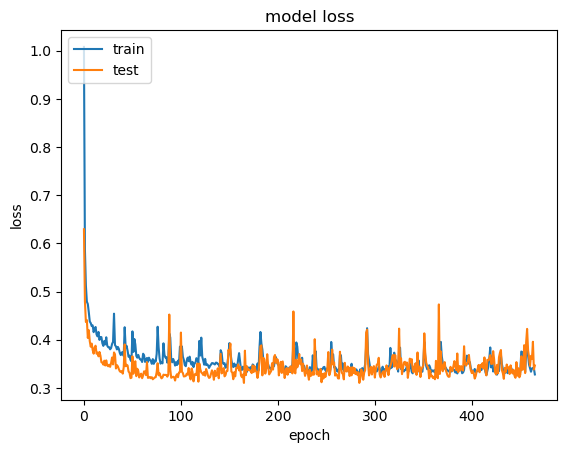

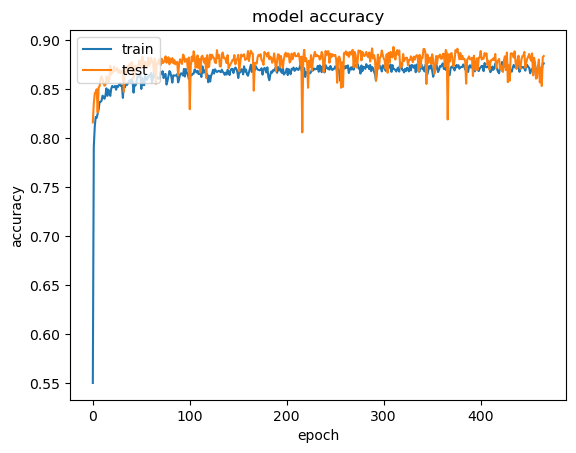

209/209 [==============================] - 5s 24ms/step


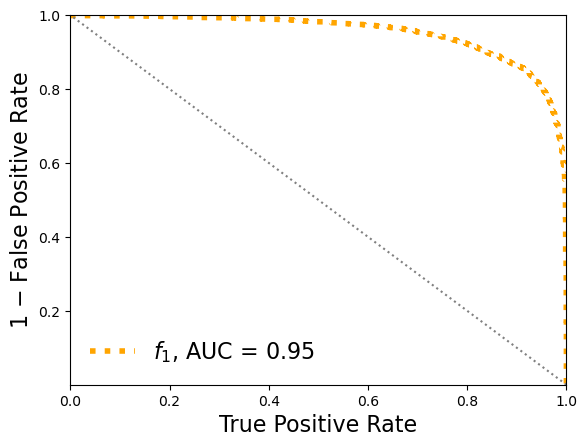

In [24]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [25]:
roc_auc_conv

0.9518897249468352

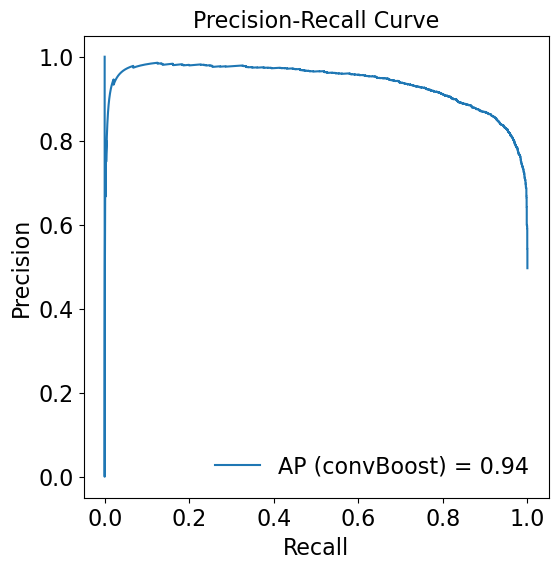

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_conv, recall_conv, _ = precision_recall_curve(y_mon1_test, y_pred_conv)
auc_conv = auc(recall_conv, precision_conv)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_conv, precision_conv, label=f'AP (convBoost) = {auc_conv:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [27]:
auc_conv

0.9386773840374937

Classification score:


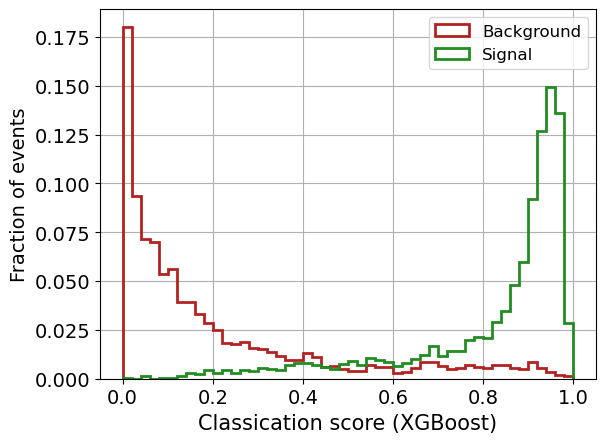

In [28]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 1 conv layer (Hits_bot and Hits_top, images) , DNN (peak S1 and peakS2, time, 64-32-16)  (final dense 64-32-16-1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_20 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 126, 126, 16  160         ['input_19[0][0]']               
                                )                                                           

                                                                                                  
 dropout_50 (Dropout)           (None, 64)           0           ['dense_39[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 32)           2080        ['dropout_50[0][0]']             
                                                                                                  
 dropout_51 (Dropout)           (None, 32)           0           ['dense_40[0][0]']               
                                                                                                  
 dense_41 (Dense)               (None, 16)           528         ['dropout_51[0][0]']             
                                                                                                  
 dropout_52 (Dropout)           (None, 16)           0           ['dense_41[0][0]']               
          

79/79 [==============================] - 26s 334ms/step - loss: 0.2001 - accuracy: 0.9294 - val_loss: 0.3328 - val_accuracy: 0.8806
Epoch 103/1500
79/79 [==============================] - 26s 324ms/step - loss: 0.1935 - accuracy: 0.9351 - val_loss: 0.3423 - val_accuracy: 0.8677
Epoch 104/1500
79/79 [==============================] - 26s 336ms/step - loss: 0.1904 - accuracy: 0.9286 - val_loss: 0.3335 - val_accuracy: 0.8767
Epoch 105/1500
79/79 [==============================] - 26s 326ms/step - loss: 0.1926 - accuracy: 0.9311 - val_loss: 0.3368 - val_accuracy: 0.8692
Epoch 106/1500
79/79 [==============================] - 26s 332ms/step - loss: 0.1991 - accuracy: 0.9286 - val_loss: 0.3274 - val_accuracy: 0.8812
Epoch 107/1500
79/79 [==============================] - 26s 330ms/step - loss: 0.2143 - accuracy: 0.9239 - val_loss: 0.3719 - val_accuracy: 0.8758
Epoch 108/1500
79/79 [==============================] - 26s 334ms/step - loss: 0.2066 - accuracy: 0.9263 - val_loss: 0.3621 - val_acc

Epoch 158/1500
79/79 [==============================] - 25s 319ms/step - loss: 0.1906 - accuracy: 0.9322 - val_loss: 0.3730 - val_accuracy: 0.8683
Epoch 159/1500
79/79 [==============================] - 25s 322ms/step - loss: 0.1761 - accuracy: 0.9360 - val_loss: 0.3958 - val_accuracy: 0.8563
Epoch 160/1500
79/79 [==============================] - 27s 341ms/step - loss: 0.1799 - accuracy: 0.9322 - val_loss: 0.3452 - val_accuracy: 0.8674
Epoch 161/1500
79/79 [==============================] - 26s 330ms/step - loss: 0.1757 - accuracy: 0.9382 - val_loss: 0.3870 - val_accuracy: 0.8719
Epoch 162/1500
79/79 [==============================] - 26s 333ms/step - loss: 0.1842 - accuracy: 0.9339 - val_loss: 0.3852 - val_accuracy: 0.8644
Epoch 163/1500
79/79 [==============================] - 27s 341ms/step - loss: 0.2021 - accuracy: 0.9266 - val_loss: 0.3759 - val_accuracy: 0.8659
Epoch 164/1500
79/79 [==============================] - 26s 330ms/step - loss: 0.2097 - accuracy: 0.9240 - val_loss: 0

Epoch 214/1500
79/79 [==============================] - 27s 348ms/step - loss: 0.1796 - accuracy: 0.9369 - val_loss: 0.4259 - val_accuracy: 0.8677
Epoch 215/1500
79/79 [==============================] - 27s 343ms/step - loss: 0.1680 - accuracy: 0.9398 - val_loss: 0.4735 - val_accuracy: 0.8695
Epoch 216/1500
79/79 [==============================] - 27s 342ms/step - loss: 0.2015 - accuracy: 0.9250 - val_loss: 0.3985 - val_accuracy: 0.8659
Epoch 217/1500
79/79 [==============================] - 27s 340ms/step - loss: 0.2056 - accuracy: 0.9279 - val_loss: 0.3577 - val_accuracy: 0.8686
Epoch 218/1500
79/79 [==============================] - 27s 338ms/step - loss: 0.1865 - accuracy: 0.9348 - val_loss: 0.4037 - val_accuracy: 0.8560
Epoch 219/1500
79/79 [==============================] - 28s 351ms/step - loss: 0.1957 - accuracy: 0.9272 - val_loss: 0.3983 - val_accuracy: 0.8626
Epoch 220/1500
79/79 [==============================] - 27s 348ms/step - loss: 0.1771 - accuracy: 0.9370 - val_loss: 0

Epoch 270/1500
79/79 [==============================] - 27s 337ms/step - loss: 0.1603 - accuracy: 0.9383 - val_loss: 0.4621 - val_accuracy: 0.8605
Epoch 271/1500
79/79 [==============================] - 26s 333ms/step - loss: 0.1497 - accuracy: 0.9446 - val_loss: 0.4611 - val_accuracy: 0.8548
Epoch 272/1500
79/79 [==============================] - 26s 334ms/step - loss: 0.1508 - accuracy: 0.9467 - val_loss: 0.4621 - val_accuracy: 0.8578
Epoch 273/1500
79/79 [==============================] - 27s 339ms/step - loss: 0.1576 - accuracy: 0.9418 - val_loss: 0.4600 - val_accuracy: 0.8641
Epoch 274/1500
79/79 [==============================] - 27s 341ms/step - loss: 0.1767 - accuracy: 0.9392 - val_loss: 0.5394 - val_accuracy: 0.8515
Epoch 275/1500
79/79 [==============================] - 27s 336ms/step - loss: 0.1934 - accuracy: 0.9309 - val_loss: 0.5303 - val_accuracy: 0.8602
Epoch 276/1500
79/79 [==============================] - 26s 335ms/step - loss: 0.1867 - accuracy: 0.9374 - val_loss: 0

Epoch 326/1500
79/79 [==============================] - 26s 326ms/step - loss: 0.1769 - accuracy: 0.9295 - val_loss: 0.4295 - val_accuracy: 0.8623
Epoch 327/1500
79/79 [==============================] - 26s 329ms/step - loss: 0.1931 - accuracy: 0.9268 - val_loss: 0.4017 - val_accuracy: 0.8686
Epoch 328/1500
79/79 [==============================] - 26s 326ms/step - loss: 0.1863 - accuracy: 0.9299 - val_loss: 0.3859 - val_accuracy: 0.8635
Epoch 329/1500
79/79 [==============================] - 25s 323ms/step - loss: 0.1854 - accuracy: 0.9262 - val_loss: 0.3933 - val_accuracy: 0.8572
Epoch 330/1500
79/79 [==============================] - 28s 349ms/step - loss: 0.2028 - accuracy: 0.9231 - val_loss: 0.4133 - val_accuracy: 0.8686
Epoch 331/1500
79/79 [==============================] - 28s 352ms/step - loss: 0.2054 - accuracy: 0.9193 - val_loss: 0.4303 - val_accuracy: 0.8614
Epoch 332/1500
79/79 [==============================] - 28s 349ms/step - loss: 0.1907 - accuracy: 0.9275 - val_loss: 0

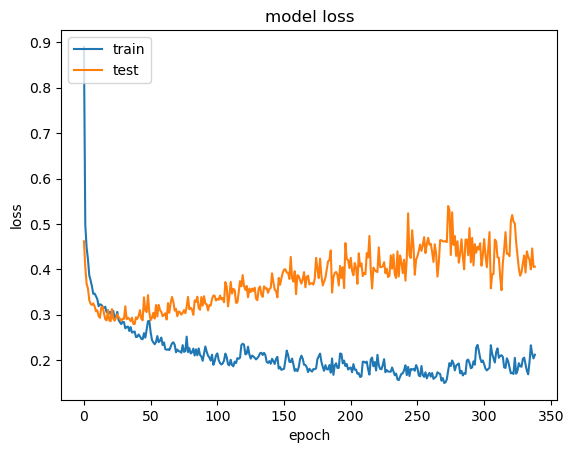

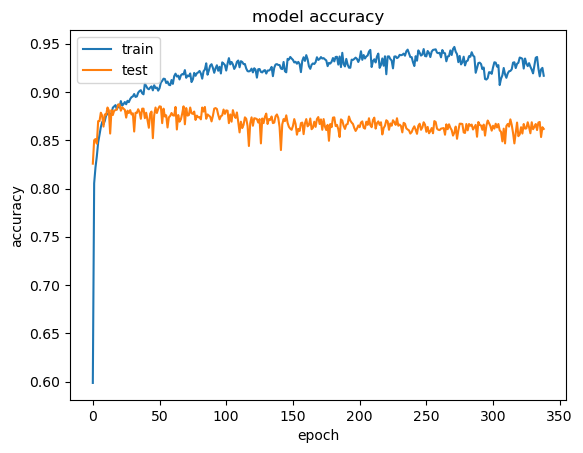

209/209 [==============================] - 4s 16ms/step


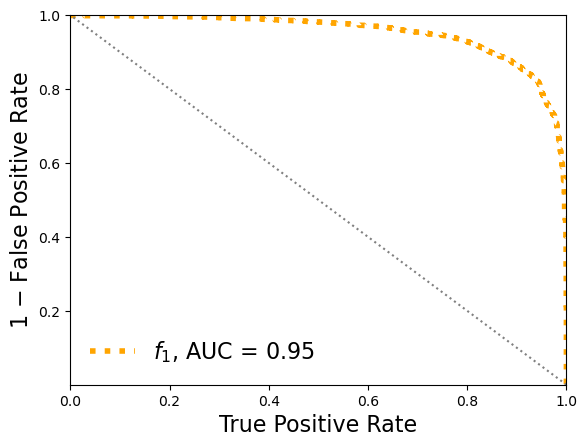

In [30]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1]))

# DNN network
conv1d_pS1 = Dense(64, activation='relu')(input_1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(32, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(16, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1]))

# Conv1D network
conv1d_pS2 = Dense(64, activation='relu')(input_1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(32, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(16, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [31]:
roc_auc_conv

0.9513853003193938

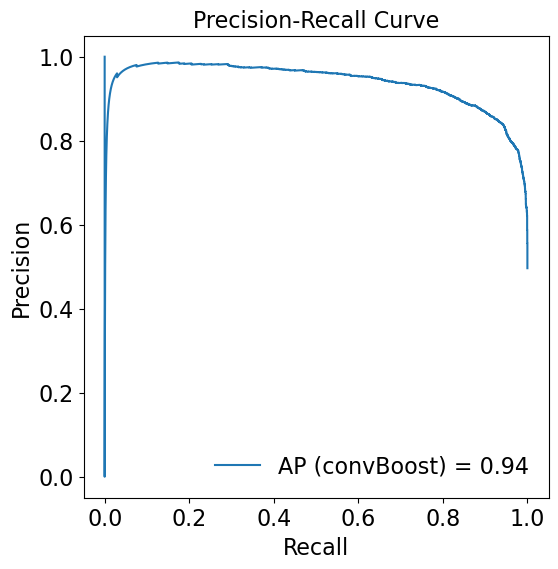

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_conv, recall_conv, _ = precision_recall_curve(y_mon1_test, y_pred_conv)
auc_conv = auc(recall_conv, precision_conv)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_conv, precision_conv, label=f'AP (convBoost) = {auc_conv:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [33]:
auc_conv

0.9383875067937397

Classification score:


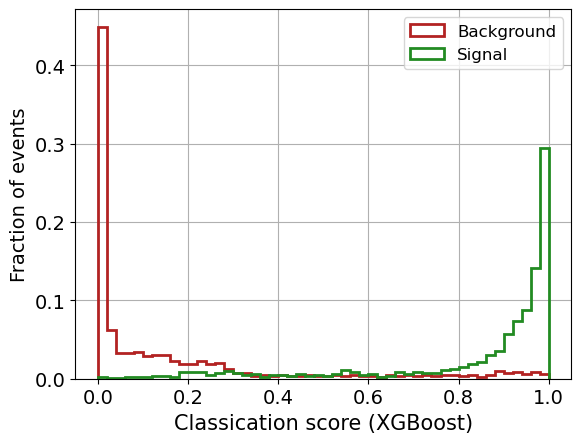

In [34]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 2 conv layer (Hits_bot and Hits_top, images) , DNN (peak S1 and peakS2, time, 64-32-16)  (final dense 64-32-16-1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_24 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 126, 126, 16  160         ['input_23[0][0]']               
                                )                                                           

 dense_50 (Dense)               (None, 16)           3810320     ['flatten_17[0][0]']             
                                                                                                  
 dense_45 (Dense)               (None, 16)           528         ['dropout_54[0][0]']             
                                                                                                  
 dense_48 (Dense)               (None, 16)           528         ['dropout_57[0][0]']             
                                                                                                  
 leaky_re_lu_40 (LeakyReLU)     (None, 16)           0           ['dense_49[0][0]']               
                                                                                                  
 leaky_re_lu_43 (LeakyReLU)     (None, 16)           0           ['dense_50[0][0]']               
                                                                                                  
 dropout_5

79/79 [==============================] - 46s 584ms/step - loss: 0.2387 - accuracy: 0.9115 - val_loss: 0.3263 - val_accuracy: 0.8722
Epoch 87/1500
79/79 [==============================] - 46s 581ms/step - loss: 0.2284 - accuracy: 0.9172 - val_loss: 0.3001 - val_accuracy: 0.8794
Epoch 88/1500
79/79 [==============================] - 47s 592ms/step - loss: 0.2236 - accuracy: 0.9193 - val_loss: 0.3309 - val_accuracy: 0.8686
Epoch 89/1500
79/79 [==============================] - 47s 592ms/step - loss: 0.2172 - accuracy: 0.9187 - val_loss: 0.3157 - val_accuracy: 0.8791
Epoch 90/1500
79/79 [==============================] - 46s 585ms/step - loss: 0.2109 - accuracy: 0.9217 - val_loss: 0.3107 - val_accuracy: 0.8770
Epoch 91/1500
79/79 [==============================] - 46s 586ms/step - loss: 0.2114 - accuracy: 0.9201 - val_loss: 0.2972 - val_accuracy: 0.8833
Epoch 92/1500
79/79 [==============================] - 46s 581ms/step - loss: 0.2029 - accuracy: 0.9242 - val_loss: 0.3077 - val_accuracy:

Epoch 142/1500
79/79 [==============================] - 48s 604ms/step - loss: 0.1957 - accuracy: 0.9279 - val_loss: 0.3250 - val_accuracy: 0.8755
Epoch 143/1500
79/79 [==============================] - 46s 581ms/step - loss: 0.1867 - accuracy: 0.9302 - val_loss: 0.3371 - val_accuracy: 0.8791
Epoch 144/1500
79/79 [==============================] - 47s 595ms/step - loss: 0.1982 - accuracy: 0.9286 - val_loss: 0.3359 - val_accuracy: 0.8716
Epoch 145/1500
79/79 [==============================] - 48s 603ms/step - loss: 0.1899 - accuracy: 0.9321 - val_loss: 0.3295 - val_accuracy: 0.8821
Epoch 146/1500
79/79 [==============================] - 47s 592ms/step - loss: 0.1912 - accuracy: 0.9307 - val_loss: 0.3382 - val_accuracy: 0.8764
Epoch 147/1500
79/79 [==============================] - 46s 587ms/step - loss: 0.1876 - accuracy: 0.9335 - val_loss: 0.3534 - val_accuracy: 0.8710
Epoch 148/1500
79/79 [==============================] - 47s 598ms/step - loss: 0.2140 - accuracy: 0.9187 - val_loss: 0

Epoch 198/1500
79/79 [==============================] - 47s 591ms/step - loss: 0.1928 - accuracy: 0.9293 - val_loss: 0.3425 - val_accuracy: 0.8752
Epoch 199/1500
79/79 [==============================] - 46s 585ms/step - loss: 0.1808 - accuracy: 0.9344 - val_loss: 0.3561 - val_accuracy: 0.8734
Epoch 200/1500
79/79 [==============================] - 47s 595ms/step - loss: 0.1831 - accuracy: 0.9310 - val_loss: 0.3429 - val_accuracy: 0.8782
Epoch 201/1500
79/79 [==============================] - 47s 598ms/step - loss: 0.1720 - accuracy: 0.9385 - val_loss: 0.3792 - val_accuracy: 0.8683
Epoch 202/1500
79/79 [==============================] - 46s 580ms/step - loss: 0.1998 - accuracy: 0.9376 - val_loss: 0.3831 - val_accuracy: 0.8698
Epoch 203/1500
79/79 [==============================] - 46s 587ms/step - loss: 0.1870 - accuracy: 0.9388 - val_loss: 0.3585 - val_accuracy: 0.8791
Epoch 204/1500
79/79 [==============================] - 47s 590ms/step - loss: 0.1803 - accuracy: 0.9369 - val_loss: 0

Epoch 254/1500
79/79 [==============================] - 46s 586ms/step - loss: 0.1776 - accuracy: 0.9341 - val_loss: 0.4075 - val_accuracy: 0.8665
Epoch 255/1500
79/79 [==============================] - 47s 595ms/step - loss: 0.1996 - accuracy: 0.9237 - val_loss: 0.3965 - val_accuracy: 0.8653
Epoch 256/1500
79/79 [==============================] - 46s 583ms/step - loss: 0.1916 - accuracy: 0.9285 - val_loss: 0.4109 - val_accuracy: 0.8707
Epoch 257/1500
79/79 [==============================] - 48s 603ms/step - loss: 0.1893 - accuracy: 0.9280 - val_loss: 0.4149 - val_accuracy: 0.8671
Epoch 258/1500
79/79 [==============================] - 47s 591ms/step - loss: 0.1889 - accuracy: 0.9302 - val_loss: 0.4083 - val_accuracy: 0.8632
Epoch 259/1500
79/79 [==============================] - 47s 600ms/step - loss: 0.1852 - accuracy: 0.9313 - val_loss: 0.4193 - val_accuracy: 0.8737
Epoch 260/1500
79/79 [==============================] - 47s 590ms/step - loss: 0.1863 - accuracy: 0.9301 - val_loss: 0

Epoch 310/1500
79/79 [==============================] - 46s 588ms/step - loss: 0.1696 - accuracy: 0.9352 - val_loss: 0.3800 - val_accuracy: 0.8671
Epoch 311/1500
79/79 [==============================] - 47s 599ms/step - loss: 0.1579 - accuracy: 0.9414 - val_loss: 0.3781 - val_accuracy: 0.8668
Epoch 312/1500
79/79 [==============================] - 46s 586ms/step - loss: 0.1494 - accuracy: 0.9455 - val_loss: 0.4306 - val_accuracy: 0.8692
Epoch 313/1500
79/79 [==============================] - 46s 580ms/step - loss: 0.1617 - accuracy: 0.9413 - val_loss: 0.3684 - val_accuracy: 0.8734
Epoch 314/1500
79/79 [==============================] - 46s 584ms/step - loss: 0.1465 - accuracy: 0.9482 - val_loss: 0.3690 - val_accuracy: 0.8722
Epoch 315/1500
79/79 [==============================] - 46s 589ms/step - loss: 0.1559 - accuracy: 0.9431 - val_loss: 0.4307 - val_accuracy: 0.8713
Epoch 316/1500
79/79 [==============================] - 46s 580ms/step - loss: 0.1488 - accuracy: 0.9449 - val_loss: 0

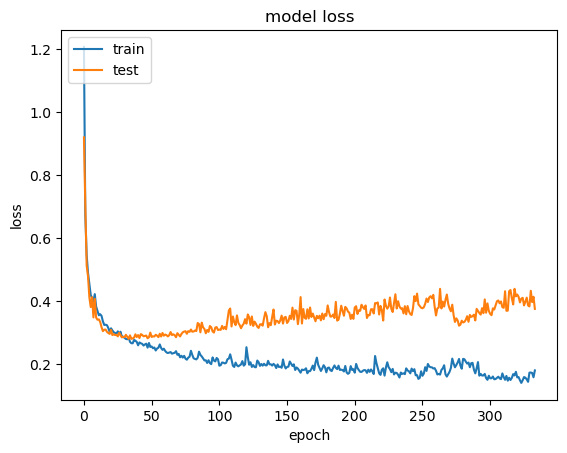

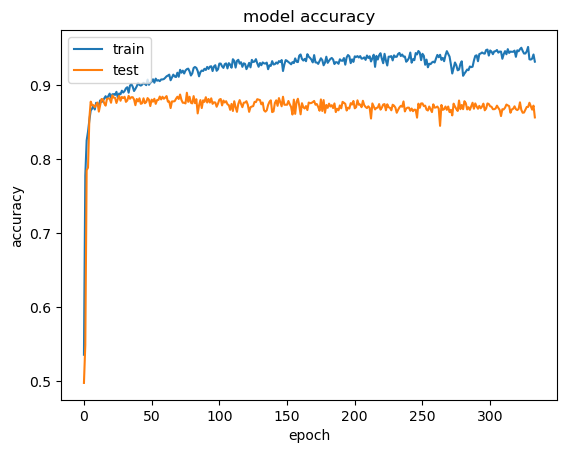

209/209 [==============================] - 5s 26ms/step


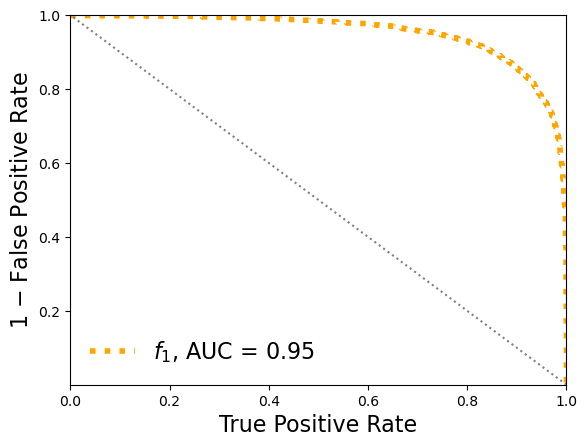

In [35]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1]))

# DNN network
conv1d_pS1 = Dense(64, activation='relu')(input_1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(32, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)
conv1d_pS1 = Dense(16, activation='relu')(conv1d_pS1)
conv1d_pS1 = Dropout(0.20)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1]))

# Conv1D network
conv1d_pS2 = Dense(64, activation='relu')(input_1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(32, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)
conv1d_pS2 = Dense(16, activation='relu')(conv1d_pS2)
conv1d_pS2 = Dropout(0.20)(conv1d_pS2)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)
conv2d_bot = Dropout(0.25)(conv2d_bot)

conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)
conv2d_top = Dropout(0.25)(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)





# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [36]:
roc_auc_conv

0.9516063741993777

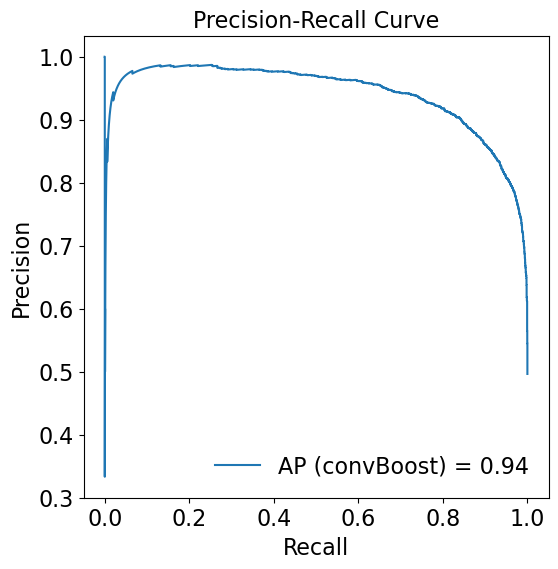

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_conv, recall_conv, _ = precision_recall_curve(y_mon1_test, y_pred_conv)
auc_conv = auc(recall_conv, precision_conv)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_conv, precision_conv, label=f'AP (convBoost) = {auc_conv:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [38]:
auc_conv

0.9408187850126116

Classification score:


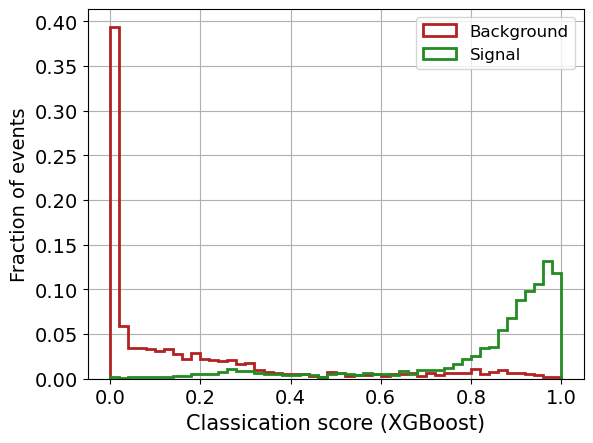

In [39]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 1 conv layer (peakS1 and Hits_bot) , 2 conv layer (peakS2 and Hits_top)  combine time in a 64-32-16 DNN, combine images in a 64-32-16 DNN (final dense 64-32-16-1)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 2244, 1)]    0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 2242, 16)     64          ['input_26[0][0]']               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 126, 126, 16  160         ['input_28[0][0]']         

                                                                                                  
 dense_61 (Dense)               (None, 16)           3810320     ['flatten_21[0][0]']             
                                                                                                  
 leaky_re_lu_45 (LeakyReLU)     (None, 16)           0           ['dense_55[0][0]']               
                                                                                                  
 leaky_re_lu_48 (LeakyReLU)     (None, 16)           0           ['dense_56[0][0]']               
                                                                                                  
 leaky_re_lu_50 (LeakyReLU)     (None, 16)           0           ['dense_60[0][0]']               
                                                                                                  
 leaky_re_lu_53 (LeakyReLU)     (None, 16)           0           ['dense_61[0][0]']               
          

79/79 [==============================] - 35s 441ms/step - loss: 0.3412 - accuracy: 0.8710 - val_loss: 0.4822 - val_accuracy: 0.7591
Epoch 70/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3486 - accuracy: 0.8680 - val_loss: 0.4377 - val_accuracy: 0.8014
Epoch 71/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3455 - accuracy: 0.8694 - val_loss: 0.4696 - val_accuracy: 0.7792
Epoch 72/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3478 - accuracy: 0.8693 - val_loss: 0.4721 - val_accuracy: 0.7855
Epoch 73/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3403 - accuracy: 0.8690 - val_loss: 0.4373 - val_accuracy: 0.7990
Epoch 74/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3401 - accuracy: 0.8745 - val_loss: 0.4074 - val_accuracy: 0.8272
Epoch 75/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3368 - accuracy: 0.8725 - val_loss: 0.4232 - val_accuracy:

79/79 [==============================] - 35s 442ms/step - loss: 0.3424 - accuracy: 0.8714 - val_loss: 0.5152 - val_accuracy: 0.7331
Epoch 126/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3355 - accuracy: 0.8735 - val_loss: 0.4853 - val_accuracy: 0.7798
Epoch 127/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3397 - accuracy: 0.8727 - val_loss: 0.4631 - val_accuracy: 0.7882
Epoch 128/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3466 - accuracy: 0.8701 - val_loss: 0.5109 - val_accuracy: 0.7496
Epoch 129/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3468 - accuracy: 0.8709 - val_loss: 0.5143 - val_accuracy: 0.7415
Epoch 130/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3317 - accuracy: 0.8733 - val_loss: 0.4750 - val_accuracy: 0.7807
Epoch 131/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3463 - accuracy: 0.8725 - val_loss: 0.5121 - val_acc

Epoch 181/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3280 - accuracy: 0.8755 - val_loss: 0.5292 - val_accuracy: 0.7418
Epoch 182/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3318 - accuracy: 0.8739 - val_loss: 0.4797 - val_accuracy: 0.7588
Epoch 183/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3334 - accuracy: 0.8755 - val_loss: 0.5760 - val_accuracy: 0.6878
Epoch 184/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3319 - accuracy: 0.8749 - val_loss: 0.4417 - val_accuracy: 0.7987
Epoch 185/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3350 - accuracy: 0.8713 - val_loss: 0.5255 - val_accuracy: 0.7588
Epoch 186/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3345 - accuracy: 0.8715 - val_loss: 0.5200 - val_accuracy: 0.7406
Epoch 187/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3403 - accuracy: 0.8702 - val_loss: 0

Epoch 237/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3401 - accuracy: 0.8726 - val_loss: 0.5213 - val_accuracy: 0.7385
Epoch 238/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3312 - accuracy: 0.8749 - val_loss: 0.6440 - val_accuracy: 0.6701
Epoch 239/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3379 - accuracy: 0.8725 - val_loss: 0.6191 - val_accuracy: 0.6830
Epoch 240/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3309 - accuracy: 0.8776 - val_loss: 0.6256 - val_accuracy: 0.6698
Epoch 241/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3351 - accuracy: 0.8719 - val_loss: 0.5578 - val_accuracy: 0.7253
Epoch 242/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3338 - accuracy: 0.8761 - val_loss: 0.6183 - val_accuracy: 0.6794
Epoch 243/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3315 - accuracy: 0.8723 - val_loss: 0

Epoch 293/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3281 - accuracy: 0.8730 - val_loss: 0.4667 - val_accuracy: 0.7771
Epoch 294/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3269 - accuracy: 0.8759 - val_loss: 0.5105 - val_accuracy: 0.7421
Epoch 295/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3299 - accuracy: 0.8737 - val_loss: 0.5677 - val_accuracy: 0.6998
Epoch 296/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3322 - accuracy: 0.8734 - val_loss: 0.5375 - val_accuracy: 0.7187
Epoch 297/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3313 - accuracy: 0.8701 - val_loss: 0.5033 - val_accuracy: 0.7499
Epoch 298/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3370 - accuracy: 0.8769 - val_loss: 0.5142 - val_accuracy: 0.7421
Epoch 299/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3314 - accuracy: 0.8747 - val_loss: 0

Epoch 349/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3356 - accuracy: 0.8722 - val_loss: 0.6222 - val_accuracy: 0.6773
Epoch 350/1500
79/79 [==============================] - 35s 442ms/step - loss: 0.3422 - accuracy: 0.8710 - val_loss: 0.5012 - val_accuracy: 0.7732
Epoch 351/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3514 - accuracy: 0.8733 - val_loss: 0.5428 - val_accuracy: 0.7334
Epoch 352/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3396 - accuracy: 0.8719 - val_loss: 0.4616 - val_accuracy: 0.7807
Epoch 353/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3317 - accuracy: 0.8737 - val_loss: 0.5767 - val_accuracy: 0.6908
Epoch 354/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3395 - accuracy: 0.8706 - val_loss: 0.4668 - val_accuracy: 0.7747
Epoch 355/1500
79/79 [==============================] - 35s 441ms/step - loss: 0.3344 - accuracy: 0.8708 - val_loss: 0

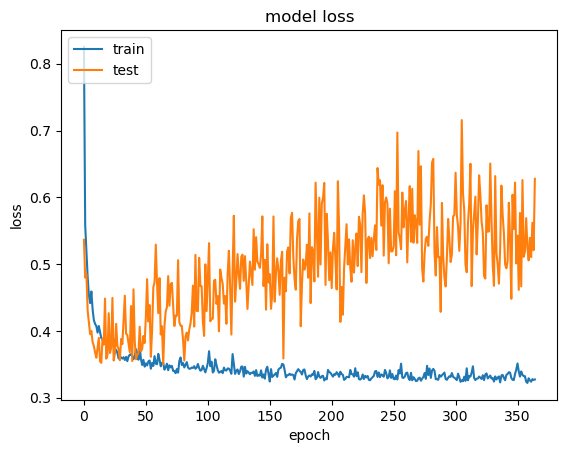

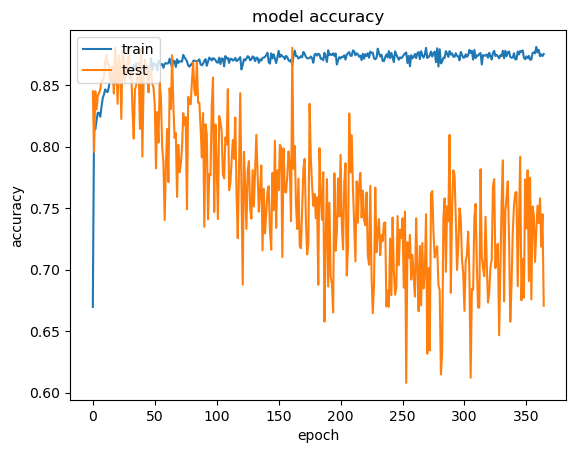

209/209 [==============================] - 5s 23ms/step


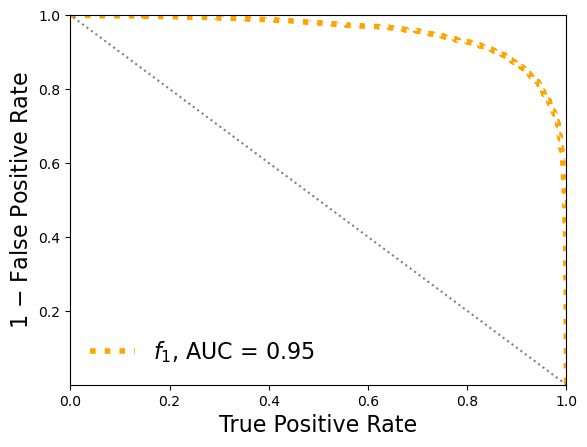

In [40]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)


# Concatenate the outputs from Conv2D and Conv1D networks
combined1 = concatenate([conv1d_pS1, conv1d_pS2])


# Dense layers
dense1 = Dense(64, activation='relu')(combined1)
dense1 = Dropout(0.20)(dense1)
dense1 = Dense(32, activation='relu')(dense1)
dense1 = Dropout(0.20)(dense1)
output1 = Dense(16, activation='relu')(dense1)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



# Concatenate the outputs from Conv2D and Conv1D networks
combined2 = concatenate([conv2d_bot, conv2d_top])


# Dense layers
dense2 = Dense(64, activation='relu')(combined2)
dense2 = Dropout(0.20)(dense2)
dense2 = Dense(32, activation='relu')(dense2)
dense2 = Dropout(0.20)(dense2)
output2 = Dense(16, activation='relu')(dense2)



# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([output1, output2])


# Dense layers
dense = Dense(64, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [41]:
roc_auc_conv

0.9517678260783483

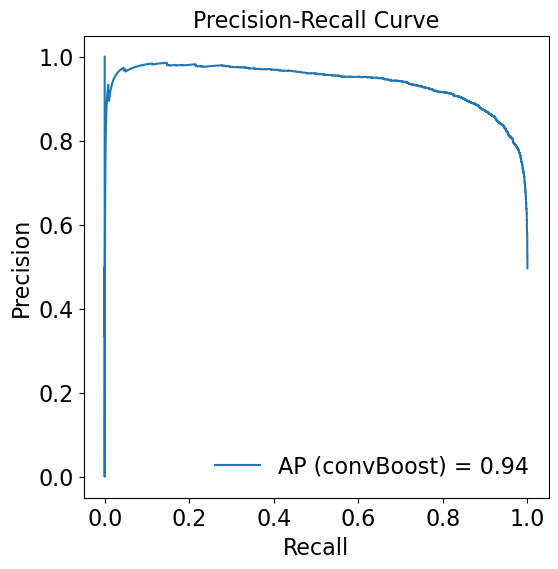

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_conv, recall_conv, _ = precision_recall_curve(y_mon1_test, y_pred_conv)
auc_conv = auc(recall_conv, precision_conv)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_conv, precision_conv, label=f'AP (convBoost) = {auc_conv:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [43]:
auc_conv

0.9385618950105039

Classification score:


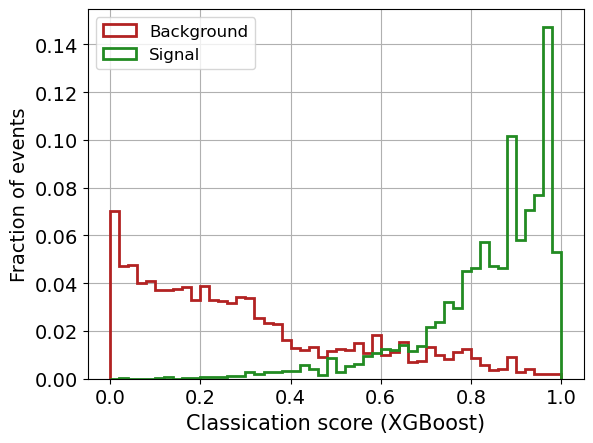

In [44]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon1_test)):
    if y_mon1_test[i] == 0:
        pred_XG_SM.append(y_pred_conv[i,0])
    else:
        pred_XG_NP.append(y_pred_conv[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 126, 126, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)      (None, 126, 126, 16  0           ['conv2d_1[0][0]']               
                                )                                                          

 dropout_18 (Dropout)           (None, 16)           0           ['dense_15[0][0]']               
                                                                                                  
 dense_16 (Dense)               (None, 8)            136         ['dropout_18[0][0]']             
                                                                                                  
 dropout_19 (Dropout)           (None, 8)            0           ['dense_16[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 1)            9           ['dropout_19[0][0]']             
                                                                                                  
Total params: 7,818,043
Trainable params: 7,818,043
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/1500
59/59 [=============

Epoch 50/1500
59/59 [==============================] - 25s 422ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 51/1500
59/59 [==============================] - 25s 423ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 52/1500
59/59 [==============================] - 26s 433ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 53/1500
59/59 [==============================] - 27s 464ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 54/1500
59/59 [==============================] - 27s 451ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 55/1500
59/59 [==============================] - 27s 458ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 56/1500
59/59 [==============================] - 26s 444ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 -

59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 107/1500
59/59 [==============================] - 24s 407ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 108/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 109/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 110/1500
59/59 [==============================] - 24s 407ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 111/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 112/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_acc

Epoch 162/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 163/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 164/1500
59/59 [==============================] - 24s 411ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 165/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 166/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 167/1500
59/59 [==============================] - 24s 407ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 168/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 218/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 219/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 220/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 221/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 222/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 223/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 224/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 274/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 275/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 276/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 277/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 278/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 279/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 280/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 330/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 331/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 332/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 333/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 334/1500
59/59 [==============================] - 24s 407ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 335/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 336/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 386/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 387/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 388/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 389/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 390/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 391/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 392/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 442/1500
59/59 [==============================] - 24s 405ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 443/1500
59/59 [==============================] - 25s 426ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 444/1500
59/59 [==============================] - 25s 428ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 445/1500
59/59 [==============================] - 26s 433ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 446/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 447/1500
59/59 [==============================] - 26s 433ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 448/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 498/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 499/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 500/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 501/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 502/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 503/1500
59/59 [==============================] - 24s 406ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 504/1500
59/59 [==============================] - 24s 407ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

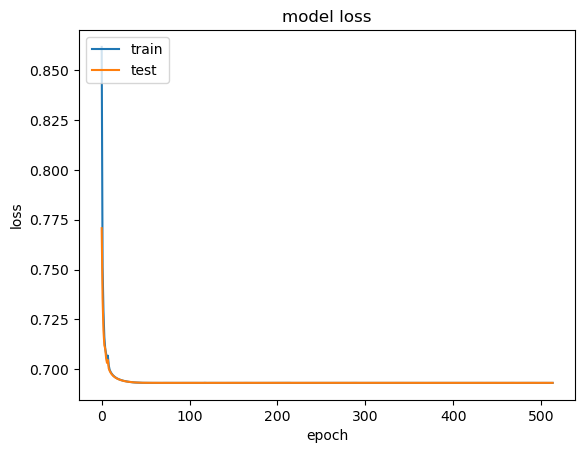

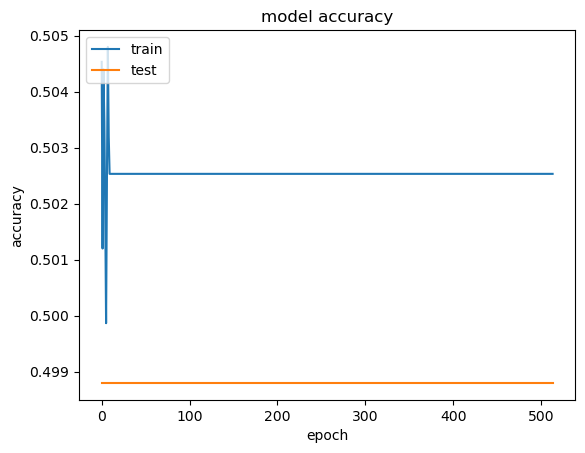

157/157 [==============================] - 3s 21ms/step


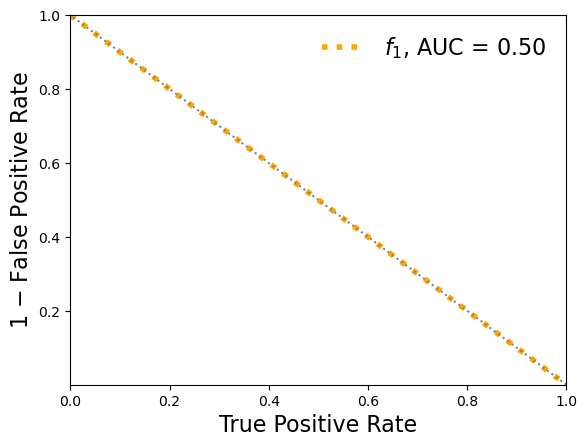

In [64]:
############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



# Concatenate the outputs from Conv2D and Conv1D networks
combined2 = concatenate([conv2d_bot, conv2d_top])


# Dense layers
dense2 = Dense(64, activation='relu')(combined2)
dense2 = Dropout(0.20)(dense2)
dense2 = Dense(32, activation='relu')(dense2)
dense2 = Dropout(0.20)(dense2)
output2 = Dense(16, activation='relu')(dense2)




# Dense layers
dense = Dropout(0.20)(output2)
dense = Dense(2, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [65]:
roc_auc_conv

0.5

79/79 [==============================] - 2s 23ms/step


/tmp/ipykernel_17000/1769866722.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_17000/1769866722.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


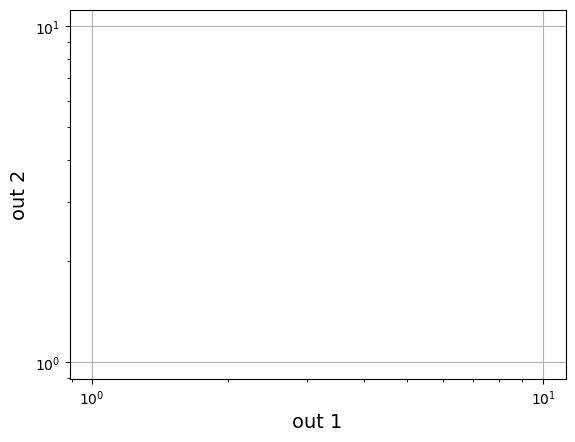

40/40 [==============================] - 1s 23ms/step


/tmp/ipykernel_17000/1769866722.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_17000/1769866722.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


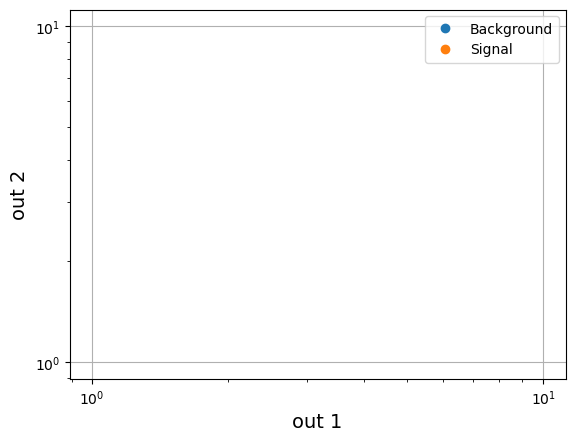

In [70]:
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_13").output)

y_pred_inter = model_inter.predict([X_mon3_val,X_mon4_val])

plt.plot(y_pred_inter[:,0], y_pred_inter[:,1], 'o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()



model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_13").output)

y_pred_inter_SM = model_inter.predict([X_mon3_val_SM,X_mon4_val_SM])
y_pred_inter_NP = model_inter.predict([X_mon3_val_NP,X_mon4_val_NP])

plt.plot(y_pred_inter_SM[:,0], y_pred_inter_SM[:,1], 'o', label='Background')
plt.plot(y_pred_inter_NP[:,0], y_pred_inter_NP[:,1], 'o', label='Signal')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.legend()
plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1863, 1)]    0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1861, 16)     64          ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 1861, 16)     0           ['conv1d_1[0][0]']               
                                                                                                  
 input_1 (InputLayer)           [(None, 168, 1)]     0           []                               
                                                                                              

2023-06-01 03:46:35.348172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-01 03:46:35.348196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pcmadrid): /proc/driver/nvidia/version does not exist
2023-06-01 03:46:35.349001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1500
59/59 [==============================] - 4s 44ms/step - loss: 0.7375 - accuracy: 0.6335 - val_loss: 0.6037 - val_accuracy: 0.8336
Epoch 2/1500
59/59 [==============================] - 2s 38ms/step - loss: 0.6368 - accuracy: 0.7132 - val_loss: 0.5373 - val_accuracy: 0.8268
Epoch 3/1500
59/59 [==============================] - 2s 38ms/step - loss: 0.5694 - accuracy: 0.7239 - val_loss: 0.4694 - val_accuracy: 0.8316
Epoch 4/1500
59/59 [==============================] - 2s 39ms/step - loss: 0.5508 - accuracy: 0.7308 - val_loss: 0.4411 - val_accuracy: 0.8420
Epoch 5/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.5265 - accuracy: 0.7445 - val_loss: 0.4406 - val_accuracy: 0.8456
Epoch 6/1500
59/59 [==============================] - 2s 37ms/step - loss: 0.5147 - accuracy: 0.7524 - val_loss: 0.4274 - val_accuracy: 0.8212
Epoch 7/1500
59/59 [==============================] - 2s 41ms/step - loss: 0.5193 - accuracy: 0.7495 - val_loss: 0.4156 - val_accuracy: 0.8400

Epoch 58/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4691 - accuracy: 0.7524 - val_loss: 0.4087 - val_accuracy: 0.8396
Epoch 59/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4715 - accuracy: 0.7585 - val_loss: 0.3943 - val_accuracy: 0.8416
Epoch 60/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4640 - accuracy: 0.7512 - val_loss: 0.3935 - val_accuracy: 0.8224
Epoch 61/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4639 - accuracy: 0.7605 - val_loss: 0.3979 - val_accuracy: 0.8344
Epoch 62/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4757 - accuracy: 0.7497 - val_loss: 0.4049 - val_accuracy: 0.8428
Epoch 63/1500
59/59 [==============================] - 2s 41ms/step - loss: 0.4627 - accuracy: 0.7581 - val_loss: 0.3951 - val_accuracy: 0.8424
Epoch 64/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4611 - accuracy: 0.7604 - val_loss: 0.3870 - val_accuracy:

Epoch 115/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4559 - accuracy: 0.7724 - val_loss: 0.3988 - val_accuracy: 0.8420
Epoch 116/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4613 - accuracy: 0.7621 - val_loss: 0.4036 - val_accuracy: 0.8284
Epoch 117/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4601 - accuracy: 0.7544 - val_loss: 0.4040 - val_accuracy: 0.8304
Epoch 118/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4575 - accuracy: 0.7655 - val_loss: 0.4027 - val_accuracy: 0.8444
Epoch 119/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4557 - accuracy: 0.7608 - val_loss: 0.3937 - val_accuracy: 0.8356
Epoch 120/1500
59/59 [==============================] - 2s 39ms/step - loss: 0.4586 - accuracy: 0.7639 - val_loss: 0.3987 - val_accuracy: 0.8232
Epoch 121/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4609 - accuracy: 0.7603 - val_loss: 0.4004 - val_ac

59/59 [==============================] - 2s 40ms/step - loss: 0.4566 - accuracy: 0.7592 - val_loss: 0.4002 - val_accuracy: 0.8248
Epoch 228/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4680 - accuracy: 0.7600 - val_loss: 0.4343 - val_accuracy: 0.8448
Epoch 229/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4685 - accuracy: 0.7667 - val_loss: 0.4283 - val_accuracy: 0.8384
Epoch 230/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4541 - accuracy: 0.7741 - val_loss: 0.4237 - val_accuracy: 0.8372
Epoch 231/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4565 - accuracy: 0.7699 - val_loss: 0.4333 - val_accuracy: 0.8432
Epoch 232/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4596 - accuracy: 0.7665 - val_loss: 0.4232 - val_accuracy: 0.8348
Epoch 233/1500
59/59 [==============================] - 2s 40ms/step - loss: 0.4635 - accuracy: 0.7573 - val_loss: 0.4346 - val_accuracy: 0.8360


59/59 [==============================] - 2s 38ms/step - loss: 0.4552 - accuracy: 0.7591 - val_loss: 0.4058 - val_accuracy: 0.8324
Epoch 340/1500
59/59 [==============================] - 2s 38ms/step - loss: 0.4578 - accuracy: 0.7623 - val_loss: 0.4023 - val_accuracy: 0.8380
Epoch 341/1500
59/59 [==============================] - 2s 37ms/step - loss: 0.4516 - accuracy: 0.7684 - val_loss: 0.4068 - val_accuracy: 0.8352
Epoch 342/1500
59/59 [==============================] - 2s 38ms/step - loss: 0.4567 - accuracy: 0.7659 - val_loss: 0.4112 - val_accuracy: 0.8444
Epoch 343/1500
59/59 [==============================] - 2s 38ms/step - loss: 0.4559 - accuracy: 0.7675 - val_loss: 0.4082 - val_accuracy: 0.8332
Epoch 344/1500
59/59 [==============================] - 2s 38ms/step - loss: 0.4631 - accuracy: 0.7564 - val_loss: 0.4164 - val_accuracy: 0.8412
Epoch 345/1500
59/59 [==============================] - 2s 38ms/step - loss: 0.4513 - accuracy: 0.7624 - val_loss: 0.4187 - val_accuracy: 0.8168


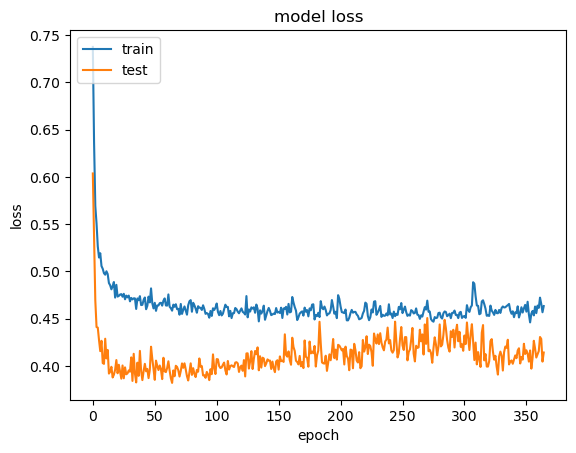

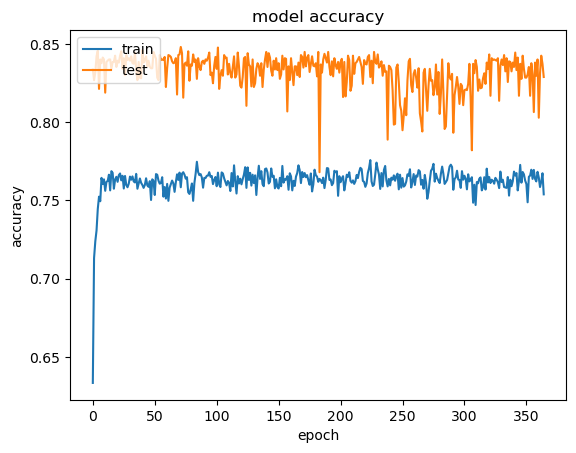

157/157 [==============================] - 0s 2ms/step


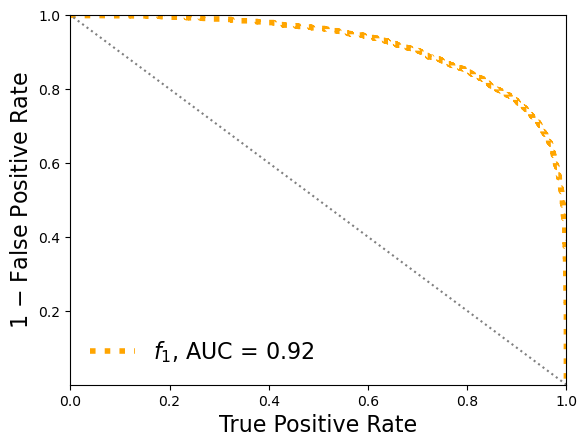

In [45]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)


# Concatenate the outputs from Conv2D and Conv1D networks
combined1 = concatenate([conv1d_pS1, conv1d_pS2])


# Dense layers
dense1 = Dense(64, activation='relu')(combined1)
dense1 = Dropout(0.20)(dense1)
dense1 = Dense(32, activation='relu')(dense1)
dense1 = Dropout(0.20)(dense1)
output1 = Dense(16, activation='relu')(dense1)



# Dense layers
dense = Dropout(0.20)(output1)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(2, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [46]:
roc_auc_conv

0.9170267614161476

79/79 [==============================] - 0s 2ms/step


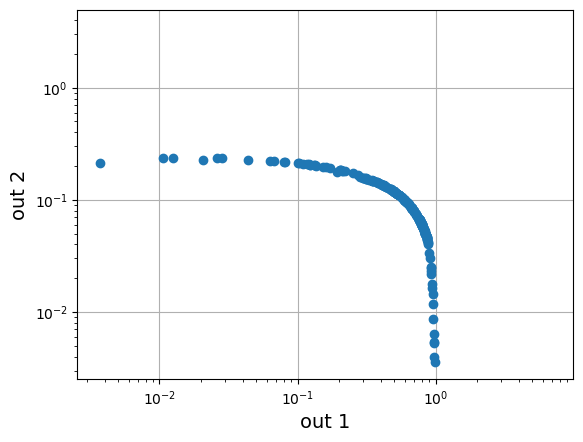

In [60]:
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_6").output)

y_pred_inter = model_inter.predict([X_mon1_val,X_mon2_val])

plt.plot(y_pred_inter[:,0], y_pred_inter[:,1], 'o')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()

40/40 [==============================] - 0s 2ms/step


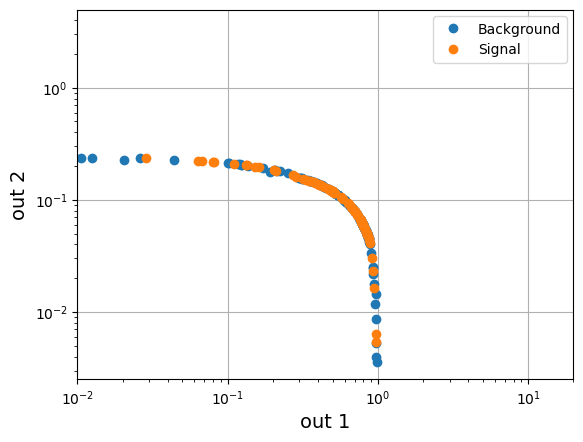

In [63]:
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_6").output)

y_pred_inter_SM = model_inter.predict([X_mon1_val_SM,X_mon2_val_SM])
y_pred_inter_NP = model_inter.predict([X_mon1_val_NP,X_mon2_val_NP])

plt.plot(y_pred_inter_SM[:,0], y_pred_inter_SM[:,1], 'o', label='Background')
plt.plot(y_pred_inter_NP[:,0], y_pred_inter_NP[:,1], 'o', label='Signal')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.legend()
plt.grid()
plt.show()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1863, 1)]    0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 1861, 16)     64          ['input_6[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 16  160         ['input_8[0][0]']         

                                                                                                  
 leaky_re_lu_11 (LeakyReLU)     (None, 16)           0           ['dense_18[0][0]']               
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 16)           0           ['dense_19[0][0]']               
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 16)           0           ['dense_23[0][0]']               
                                                                                                  
 leaky_re_lu_19 (LeakyReLU)     (None, 16)           0           ['dense_24[0][0]']               
                                                                                                  
 dropout_21 (Dropout)           (None, 16)           0           ['leaky_re_lu_11[0][0]']         
          

Epoch 8/1500
59/59 [==============================] - 29s 491ms/step - loss: 0.5031 - accuracy: 0.8013 - val_loss: 0.4388 - val_accuracy: 0.8348
Epoch 9/1500
59/59 [==============================] - 28s 467ms/step - loss: 0.5062 - accuracy: 0.7971 - val_loss: 0.4594 - val_accuracy: 0.8316
Epoch 10/1500
59/59 [==============================] - 27s 460ms/step - loss: 0.4946 - accuracy: 0.7999 - val_loss: 0.4604 - val_accuracy: 0.8336
Epoch 11/1500
59/59 [==============================] - 27s 458ms/step - loss: 0.4931 - accuracy: 0.7976 - val_loss: 0.4407 - val_accuracy: 0.8340
Epoch 12/1500
59/59 [==============================] - 27s 457ms/step - loss: 0.4840 - accuracy: 0.8065 - val_loss: 0.4465 - val_accuracy: 0.8380
Epoch 13/1500
59/59 [==============================] - 27s 465ms/step - loss: 0.4840 - accuracy: 0.8051 - val_loss: 0.4387 - val_accuracy: 0.8456
Epoch 14/1500
59/59 [==============================] - 27s 463ms/step - loss: 0.4749 - accuracy: 0.8113 - val_loss: 0.4629 - v

59/59 [==============================] - 29s 494ms/step - loss: 0.3973 - accuracy: 0.8511 - val_loss: 0.5749 - val_accuracy: 0.7580
Epoch 121/1500
59/59 [==============================] - 30s 503ms/step - loss: 0.4010 - accuracy: 0.8459 - val_loss: 0.5866 - val_accuracy: 0.7464
Epoch 122/1500
59/59 [==============================] - 29s 486ms/step - loss: 0.3881 - accuracy: 0.8620 - val_loss: 0.5819 - val_accuracy: 0.7548
Epoch 123/1500
59/59 [==============================] - 29s 489ms/step - loss: 0.4043 - accuracy: 0.8472 - val_loss: 0.5347 - val_accuracy: 0.7804
Epoch 124/1500
59/59 [==============================] - 29s 488ms/step - loss: 0.4169 - accuracy: 0.8428 - val_loss: 0.6963 - val_accuracy: 0.6924
Epoch 125/1500
59/59 [==============================] - 29s 500ms/step - loss: 0.4061 - accuracy: 0.8528 - val_loss: 0.4729 - val_accuracy: 0.8288
Epoch 126/1500
59/59 [==============================] - 29s 490ms/step - loss: 0.4057 - accuracy: 0.8527 - val_loss: 0.4945 - val_acc

Epoch 176/1500
59/59 [==============================] - 27s 464ms/step - loss: 0.3966 - accuracy: 0.8484 - val_loss: 0.8200 - val_accuracy: 0.5964
Epoch 177/1500
59/59 [==============================] - 27s 465ms/step - loss: 0.4021 - accuracy: 0.8493 - val_loss: 0.5775 - val_accuracy: 0.7436
Epoch 178/1500
59/59 [==============================] - 27s 464ms/step - loss: 0.3962 - accuracy: 0.8503 - val_loss: 0.6426 - val_accuracy: 0.6952
Epoch 179/1500
59/59 [==============================] - 27s 464ms/step - loss: 0.3989 - accuracy: 0.8508 - val_loss: 0.5774 - val_accuracy: 0.7324
Epoch 180/1500
59/59 [==============================] - 27s 464ms/step - loss: 0.3984 - accuracy: 0.8468 - val_loss: 0.5420 - val_accuracy: 0.7408
Epoch 181/1500
59/59 [==============================] - 27s 463ms/step - loss: 0.3999 - accuracy: 0.8521 - val_loss: 0.5984 - val_accuracy: 0.7120
Epoch 182/1500
59/59 [==============================] - 27s 465ms/step - loss: 0.3913 - accuracy: 0.8531 - val_loss: 0

Epoch 232/1500
59/59 [==============================] - 27s 452ms/step - loss: 0.4081 - accuracy: 0.8472 - val_loss: 0.6501 - val_accuracy: 0.6952
Epoch 233/1500
59/59 [==============================] - 28s 472ms/step - loss: 0.4058 - accuracy: 0.8489 - val_loss: 0.6908 - val_accuracy: 0.6784
Epoch 234/1500
59/59 [==============================] - 27s 462ms/step - loss: 0.3968 - accuracy: 0.8523 - val_loss: 0.6405 - val_accuracy: 0.6984
Epoch 235/1500
59/59 [==============================] - 27s 456ms/step - loss: 0.3901 - accuracy: 0.8584 - val_loss: 0.6570 - val_accuracy: 0.6904
Epoch 236/1500
59/59 [==============================] - 26s 442ms/step - loss: 0.3891 - accuracy: 0.8549 - val_loss: 0.5586 - val_accuracy: 0.7416
Epoch 237/1500
59/59 [==============================] - 26s 449ms/step - loss: 0.3954 - accuracy: 0.8459 - val_loss: 0.5477 - val_accuracy: 0.7560
Epoch 238/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.3871 - accuracy: 0.8571 - val_loss: 0

Epoch 288/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.3983 - accuracy: 0.8545 - val_loss: 0.5713 - val_accuracy: 0.7296
Epoch 289/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.3937 - accuracy: 0.8531 - val_loss: 0.6643 - val_accuracy: 0.6848
Epoch 290/1500
59/59 [==============================] - 28s 470ms/step - loss: 0.3980 - accuracy: 0.8513 - val_loss: 0.6022 - val_accuracy: 0.7056
Epoch 291/1500
59/59 [==============================] - 28s 476ms/step - loss: 0.3956 - accuracy: 0.8516 - val_loss: 0.7145 - val_accuracy: 0.6448
Epoch 292/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.4190 - accuracy: 0.8449 - val_loss: 0.6141 - val_accuracy: 0.7144
Epoch 293/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.3999 - accuracy: 0.8565 - val_loss: 0.5726 - val_accuracy: 0.7300
Epoch 294/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.3957 - accuracy: 0.8573 - val_loss: 0

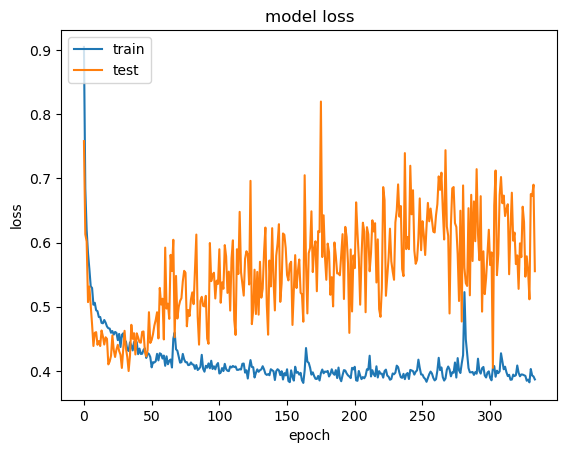

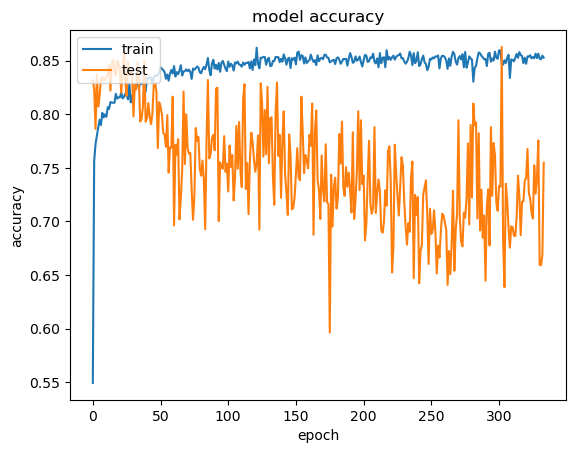

157/157 [==============================] - 4s 23ms/step


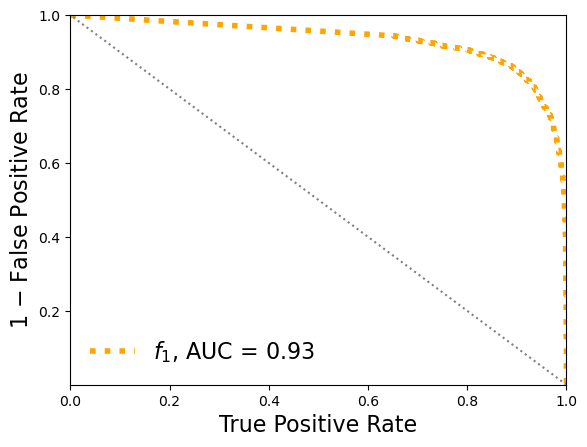

In [71]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)


# Concatenate the outputs from Conv2D and Conv1D networks
combined1 = concatenate([conv1d_pS1, conv1d_pS2])


# Dense layers
dense1 = Dense(64, activation='relu')(combined1)
dense1 = Dropout(0.20)(dense1)
dense1 = Dense(32, activation='relu')(dense1)
dense1 = Dropout(0.20)(dense1)
output1 = Dense(16, activation='relu')(dense1)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



# Concatenate the outputs from Conv2D and Conv1D networks
combined2 = concatenate([conv2d_bot, conv2d_top])


# Dense layers
dense2 = Dense(64, activation='relu')(combined2)
dense2 = Dropout(0.20)(dense2)
dense2 = Dense(32, activation='relu')(dense2)
dense2 = Dropout(0.20)(dense2)
output2 = Dense(16, activation='relu')(dense2)



# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([output1, output2])

# Dense layers
dense = Dropout(0.20)(combined)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(2, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [72]:
roc_auc_conv

0.9324500331533581

79/79 [==============================] - 2s 24ms/step


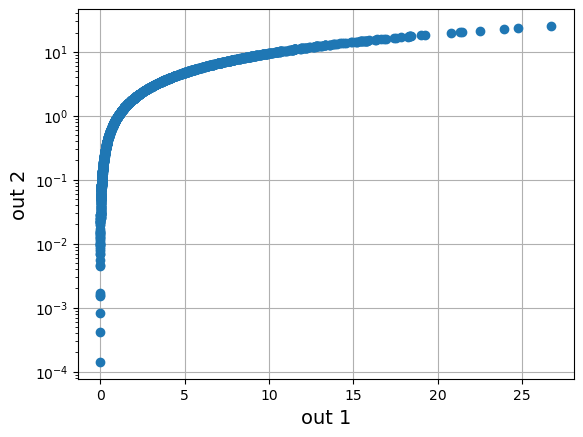

40/40 [==============================] - 1s 24ms/step


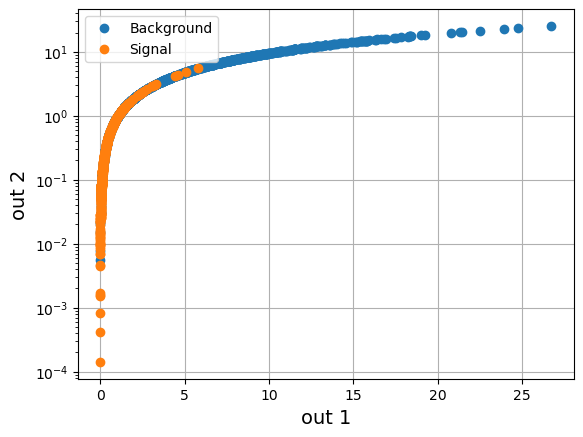

In [75]:
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_29").output)

y_pred_inter = model_inter.predict([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val])

plt.plot(y_pred_inter[:,0], y_pred_inter[:,1], 'o')
#plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()



model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_29").output)

y_pred_inter_SM = model_inter.predict([X_mon1_val_SM,X_mon2_val_SM,X_mon3_val_SM,X_mon4_val_SM])
y_pred_inter_NP = model_inter.predict([X_mon1_val_NP,X_mon2_val_NP,X_mon3_val_NP,X_mon4_val_NP])

plt.plot(y_pred_inter_SM[:,0], y_pred_inter_SM[:,1], 'o', label='Background')
plt.plot(y_pred_inter_NP[:,0], y_pred_inter_NP[:,1], 'o', label='Signal')
#plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.legend()
plt.show()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 1863, 1)]    0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 1861, 16)     64          ['input_18[0][0]']               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 126, 126, 16  160         ['input_20[0][0]']        

 dense_71 (Dense)               (None, 16)           4000016     ['flatten_18[0][0]']             
                                                                                                  
 dense_72 (Dense)               (None, 16)           3810320     ['flatten_19[0][0]']             
                                                                                                  
 leaky_re_lu_41 (LeakyReLU)     (None, 16)           0           ['dense_66[0][0]']               
                                                                                                  
 leaky_re_lu_44 (LeakyReLU)     (None, 16)           0           ['dense_67[0][0]']               
                                                                                                  
 leaky_re_lu_46 (LeakyReLU)     (None, 16)           0           ['dense_71[0][0]']               
                                                                                                  
 leaky_re_

Epoch 6/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.7100 - accuracy: 0.5060 - val_loss: 0.7043 - val_accuracy: 0.5012
Epoch 7/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.7027 - accuracy: 0.5001 - val_loss: 0.7007 - val_accuracy: 0.5012
Epoch 8/1500
59/59 [==============================] - 26s 444ms/step - loss: 0.7009 - accuracy: 0.5043 - val_loss: 0.6986 - val_accuracy: 0.5012
Epoch 9/1500
59/59 [==============================] - 26s 444ms/step - loss: 0.6988 - accuracy: 0.4915 - val_loss: 0.6976 - val_accuracy: 0.5012
Epoch 10/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.6970 - accuracy: 0.5031 - val_loss: 0.6969 - val_accuracy: 0.4988
Epoch 11/1500
59/59 [==============================] - 26s 444ms/step - loss: 0.6967 - accuracy: 0.5053 - val_loss: 0.6971 - val_accuracy: 0.4988
Epoch 12/1500
59/59 [==============================] - 26s 444ms/step - loss: 0.6962 - accuracy: 0.4939 - val_loss: 0.6959 - val

59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 119/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 120/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 121/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 122/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 123/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 124/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_acc

Epoch 174/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 175/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 176/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 177/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 178/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 179/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 180/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 230/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 231/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 232/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 233/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 234/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 235/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 236/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 286/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 287/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 288/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 289/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 290/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 291/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 292/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 342/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 343/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 344/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 345/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 346/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 347/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 348/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 398/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 399/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 400/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 401/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 402/1500
59/59 [==============================] - 26s 443ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 403/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 404/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 454/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 455/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 456/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 457/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 458/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 459/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 460/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 510/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 511/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 512/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 513/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 514/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 515/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 516/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 566/1500
59/59 [==============================] - 26s 442ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 567/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 568/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 569/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 570/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 571/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 572/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 622/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 623/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 624/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 625/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 626/1500
59/59 [==============================] - 26s 442ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 627/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 628/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 678/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 679/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 680/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 681/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 682/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 683/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 684/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 734/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 735/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 736/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 737/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 738/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 739/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 740/1500
59/59 [==============================] - 26s 442ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 790/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 791/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 792/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 793/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 794/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 795/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 796/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0

Epoch 846/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 847/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 848/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 849/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 850/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 851/1500
59/59 [==============================] - 26s 440ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 852/1500
59/59 [==============================] - 26s 441ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0

Epoch 900: early stopping


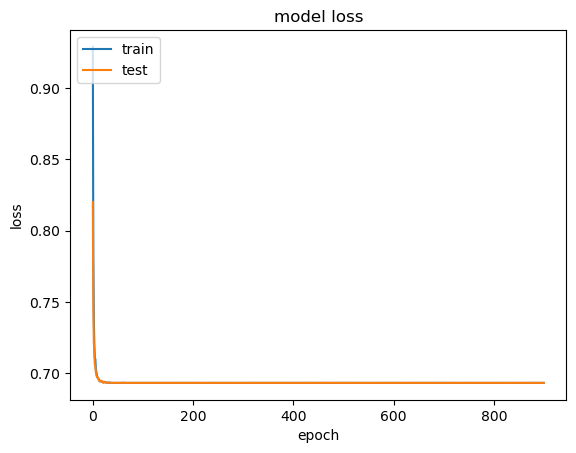

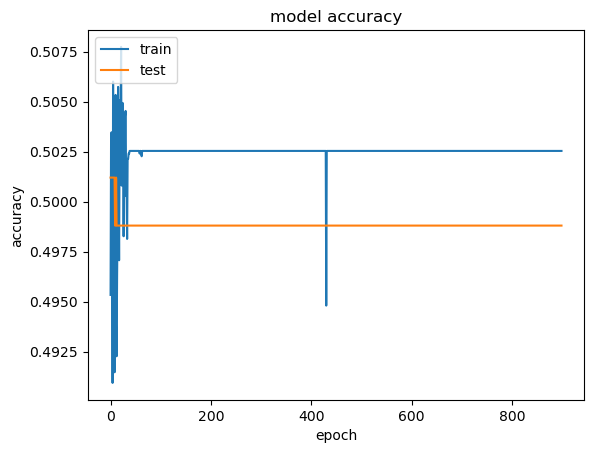

157/157 [==============================] - 4s 24ms/step


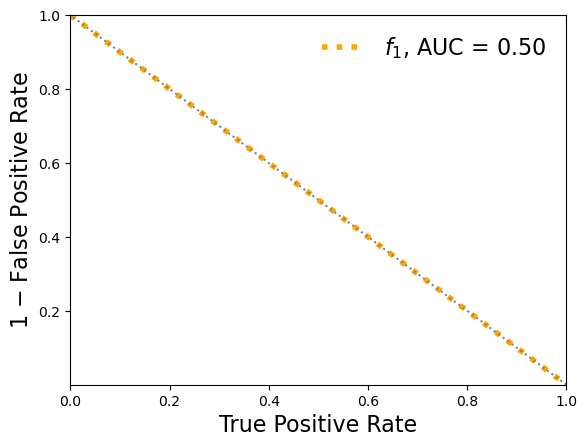

In [82]:
##########
# peakS1 #
##########

input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

# Conv1D network
conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
conv1d_pS1 = Flatten()(conv1d_pS1)

conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
conv1d_pS1 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS1)
conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



##########
# peakS2 #
##########

input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

# Conv1D network
conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
conv1d_pS2 = Flatten()(conv1d_pS2)

conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
conv1d_pS2 = keras.layers.LeakyReLU(alpha=0.05)(conv1d_pS2)
conv1d_pS2 = Dropout(0.5)(conv1d_pS2)


# Concatenate the outputs from Conv2D and Conv1D networks
combined1 = concatenate([conv1d_pS1, conv1d_pS2])


# Dense layers
dense1 = Dense(64, activation='relu')(combined1)
dense1 = Dropout(0.20)(dense1)
dense1 = Dense(32, activation='relu')(dense1)
dense1 = Dropout(0.20)(dense1)
output1 = Dense(16, activation='relu')(dense1)



############
# HITS_bot #
############

input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

# Conv2D network
conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

conv2d_bot = Dropout(0.25)(conv2d_bot)
conv2d_bot = Flatten()(conv2d_bot)

conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
conv2d_bot = keras.layers.LeakyReLU(alpha=0.05)(conv2d_bot)
conv2d_bot = Dropout(0.5)(conv2d_bot)



############
# HITS_top #
############

input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

# Conv2D network
conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

conv2d_top = Dropout(0.25)(conv2d_top)
conv2d_top = Flatten()(conv2d_top)

conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
conv2d_top = keras.layers.LeakyReLU(alpha=0.05)(conv2d_top)
conv2d_top = Dropout(0.5)(conv2d_top)



# Concatenate the outputs from Conv2D and Conv1D networks
combined2 = concatenate([conv2d_bot, conv2d_top])


# Dense layers
dense2 = Dense(64, activation='relu')(combined2)
dense2 = Dropout(0.20)(dense2)
dense2 = Dense(32, activation='relu')(dense2)
dense2 = Dropout(0.20)(dense2)
output2 = Dense(16, activation='relu')(dense2)



# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([output1, output2])

# Dense layers
dense = Dropout(0.20)(combined)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(2, activation='tanh')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)

# Print the model summary
model.summary()





# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],
                    y_mon1_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

# Compute ROC curve and ROC area for each class
fpr_conv = dict()
tpr_conv = dict()
roc_auc_conv = dict()
fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
roc_auc_conv = auc(fpr_conv, tpr_conv)


plt.figure()
plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [83]:
roc_auc_conv

0.5

79/79 [==============================] - 2s 24ms/step


/tmp/ipykernel_17000/3196030706.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


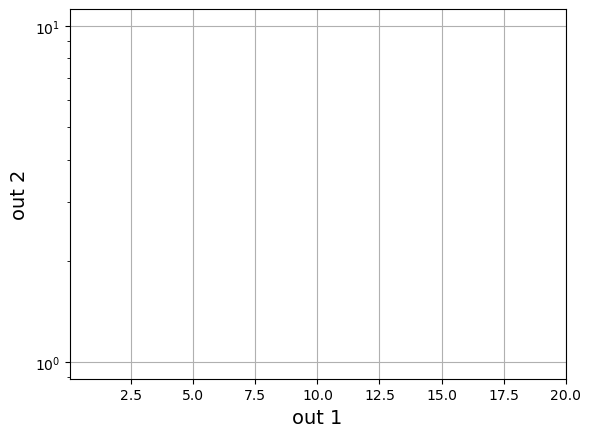

40/40 [==============================] - 1s 23ms/step


/tmp/ipykernel_17000/3196030706.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


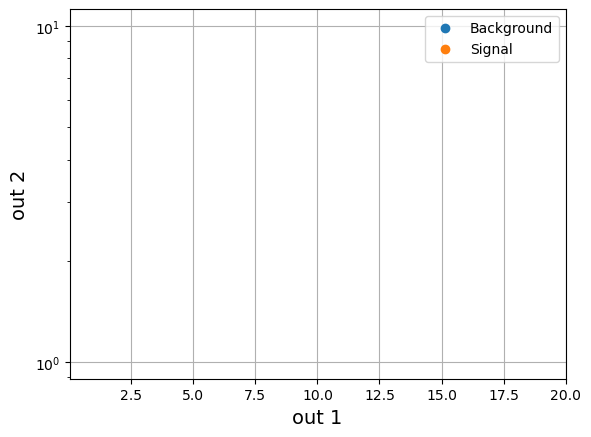

In [84]:
model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_77").output)

y_pred_inter = model_inter.predict([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val])

plt.plot(y_pred_inter[:,0], y_pred_inter[:,1], 'o')
#plt.xscale('log')
plt.yscale('log')
plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.show()



model_inter = Model(inputs=model.input,
                    outputs=model.get_layer("dense_77").output)

y_pred_inter_SM = model_inter.predict([X_mon1_val_SM,X_mon2_val_SM,X_mon3_val_SM,X_mon4_val_SM])
y_pred_inter_NP = model_inter.predict([X_mon1_val_NP,X_mon2_val_NP,X_mon3_val_NP,X_mon4_val_NP])

plt.plot(y_pred_inter_SM[:,0], y_pred_inter_SM[:,1], 'o', label='Background')
plt.plot(y_pred_inter_NP[:,0], y_pred_inter_NP[:,1], 'o', label='Signal')
#plt.xscale('log')
plt.yscale('log')
plt.xlim([0.01,20])
plt.xlabel(r"out 1",fontsize=14)
plt.ylabel("out 2",fontsize=14)
plt.grid()
plt.legend()
plt.show()

### Grid search of hyperparameters

In [21]:
def create_model(conv_layers_pS1, conv_layers_pS2, conv_layers_bot, conv_layers_top, learning_rate, alpha_value):

    ##########
    # peakS1 #
    ##########

    input_1d_pS1 = Input(shape=(X_mon1_train.shape[1], 1))

    # Conv1D network
    conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS1)
    conv1d_pS1 = keras.layers.LeakyReLU(alpha = alpha_value)(conv1d_pS1)
    conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)
    
    for i in range(1,conv_layers_pS1):
        conv1d_pS1 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS1)
        conv1d_pS1 = keras.layers.LeakyReLU(alpha = alpha_value)(conv1d_pS1)
        conv1d_pS1 = MaxPooling1D(2, strides = (1))(conv1d_pS1)

    conv1d_pS1 = Dropout(0.25)(conv1d_pS1)
    conv1d_pS1 = Flatten()(conv1d_pS1)

    conv1d_pS1 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS1)
    conv1d_pS1 = keras.layers.LeakyReLU(alpha = alpha_value)(conv1d_pS1)
    conv1d_pS1 = Dropout(0.5)(conv1d_pS1)



    ##########
    # peakS2 #
    ##########

    input_1d_pS2 = Input(shape=(X_mon2_train.shape[1], 1))

    # Conv1D network
    conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(input_1d_pS2)
    conv1d_pS2 = keras.layers.LeakyReLU(alpha = alpha_value)(conv1d_pS2)
    conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)
    
    for i in range(1,conv_layers_pS2):
        conv1d_pS2 = Conv1D(16, 3, strides = (1),kernel_regularizer=l2(0.005))(conv1d_pS2)
        conv1d_pS2 = keras.layers.LeakyReLU(alpha = alpha_value)(conv1d_pS2)
        conv1d_pS2 = MaxPooling1D(2, strides = (1))(conv1d_pS2)

    conv1d_pS2 = Dropout(0.25)(conv1d_pS2)
    conv1d_pS2 = Flatten()(conv1d_pS2)

    conv1d_pS2 = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv1d_pS2)
    conv1d_pS2 = keras.layers.LeakyReLU(alpha = alpha_value)(conv1d_pS2)
    conv1d_pS2 = Dropout(0.5)(conv1d_pS2)



    ############
    # HITS_bot #
    ############

    input_2d_bot = Input(shape=(X_mon3_train.shape[1], X_mon3_train.shape[2], X_mon3_train.shape[3]))

    # Conv2D network
    conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_bot)
    conv2d_bot = keras.layers.LeakyReLU(alpha = alpha_value)(conv2d_bot)
    conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)
    
    for i in range(1,conv_layers_bot):
        conv2d_bot = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_bot)
        conv2d_bot = keras.layers.LeakyReLU(alpha = alpha_value)(conv2d_bot)
        conv2d_bot = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_bot)

    conv2d_bot = Dropout(0.25)(conv2d_bot)
    conv2d_bot = Flatten()(conv2d_bot)

    conv2d_bot = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_bot)
    conv2d_bot = keras.layers.LeakyReLU(alpha = alpha_value)(conv2d_bot)
    conv2d_bot = Dropout(0.5)(conv2d_bot)



    ############
    # HITS_top #
    ############

    input_2d_top = Input(shape=(X_mon4_train.shape[1], X_mon4_train.shape[2], X_mon4_train.shape[3]))

    # Conv2D network
    conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d_top)
    conv2d_top = keras.layers.LeakyReLU(alpha = alpha_value)(conv2d_top)
    conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)
    
    for i in range(1,conv_layers_top):
        conv2d_top = Conv2D(16, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(conv2d_top)
        conv2d_top = keras.layers.LeakyReLU(alpha = alpha_value)(conv2d_top)
        conv2d_top = MaxPooling2D(pool_size=(2, 2), strides = (1,1))(conv2d_top)

    conv2d_top = Dropout(0.25)(conv2d_top)
    conv2d_top = Flatten()(conv2d_top)

    conv2d_top = Dense(16, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d_top)
    conv2d_top = keras.layers.LeakyReLU(alpha = alpha_value)(conv2d_top)
    conv2d_top = Dropout(0.5)(conv2d_top)





    # Concatenate the outputs from Conv2D and Conv1D networks
    combined = concatenate([conv1d_pS1, conv1d_pS2, conv2d_bot, conv2d_top])


    # Dense layers
    dense = Dense(64, activation='relu')(combined)
    dense = Dropout(0.20)(dense)
    dense = Dense(32, activation='relu')(dense)
    dense = Dropout(0.20)(dense)
    dense = Dense(16, activation='relu')(dense)
    dense = Dropout(0.20)(dense)
    output = Dense(1, activation='sigmoid')(dense)

    # Create the model
    model = Model(inputs=[input_1d_pS1, input_1d_pS2, input_2d_bot, input_2d_top], outputs=output)
    
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

###############################
 TESTING: 
conv_layers_pS1 :  1
conv_layers_pS2 :  1
conv_layers_bot :  1
conv_layers_top :  2
learning_rate :  0.001
alpha_value :  0.05
batch_size :  64
 


/home/andres/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/500
79/79 [==============================] - 18s 218ms/step - loss: 1.0439 - accuracy: 0.5147 - val_loss: 0.7930 - val_accuracy: 0.5843
Epoch 2/500
79/79 [==============================] - 17s 212ms/step - loss: 0.7005 - accuracy: 0.6665 - val_loss: 0.4904 - val_accuracy: 0.8362
Epoch 3/500
79/79 [==============================] - 17s 212ms/step - loss: 0.5538 - accuracy: 0.8054 - val_loss: 0.4677 - val_accuracy: 0.8266
Epoch 4/500
79/79 [==============================] - 17s 213ms/step - loss: 0.5064 - accuracy: 0.8198 - val_loss: 0.4449 - val_accuracy: 0.8386
Epoch 5/500
79/79 [==============================] - 17s 212ms/step - loss: 0.4798 - accuracy: 0.8316 - val_loss: 0.4468 - val_accuracy: 0.8230
Epoch 6/500
79/79 [==============================] - 17s 212ms/step - loss: 0.4615 - accuracy: 0.8362 - val_loss: 0.4220 - val_accuracy: 0.8284
Epoch 7/500
79/79 [==============================] - 17s 212ms/step - loss: 0.4579 - accuracy: 0.8334 - val_loss: 0.4272 - val_accuracy:

79/79 [==============================] - 17s 217ms/step - loss: 0.3532 - accuracy: 0.8664 - val_loss: 0.3600 - val_accuracy: 0.8716
Epoch 114/500
79/79 [==============================] - 17s 217ms/step - loss: 0.3533 - accuracy: 0.8660 - val_loss: 0.3676 - val_accuracy: 0.8638
Epoch 115/500
79/79 [==============================] - 17s 217ms/step - loss: 0.3451 - accuracy: 0.8736 - val_loss: 0.3690 - val_accuracy: 0.8662
Epoch 116/500
79/79 [==============================] - 17s 217ms/step - loss: 0.3675 - accuracy: 0.8582 - val_loss: 0.4658 - val_accuracy: 0.8548
Epoch 117/500
79/79 [==============================] - 17s 218ms/step - loss: 0.4071 - accuracy: 0.8632 - val_loss: 0.4007 - val_accuracy: 0.8578
Epoch 118/500
79/79 [==============================] - 17s 217ms/step - loss: 0.3895 - accuracy: 0.8578 - val_loss: 0.3853 - val_accuracy: 0.8656
Epoch 119/500
79/79 [==============================] - 17s 217ms/step - loss: 0.3625 - accuracy: 0.8690 - val_loss: 0.3659 - val_accuracy:

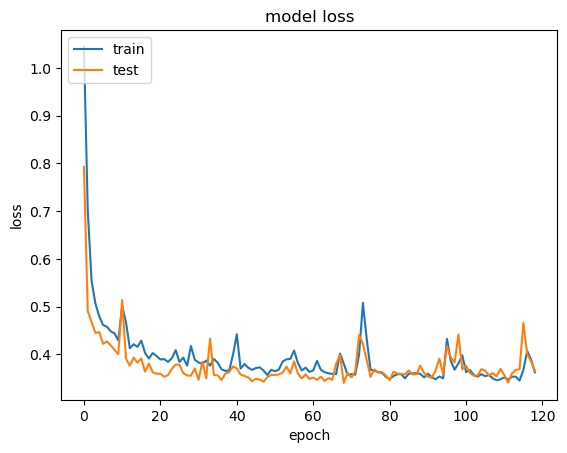

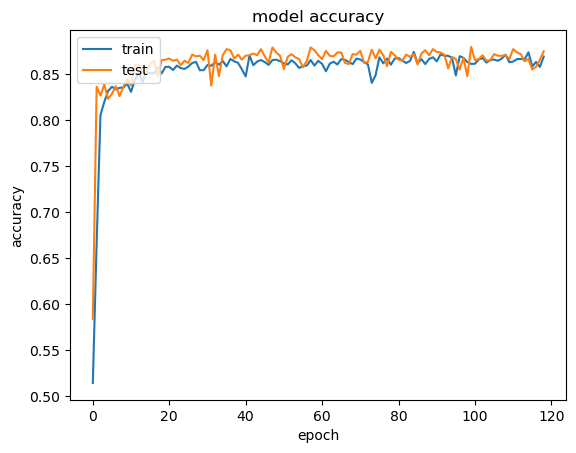

105/105 [==============================] - 3s 23ms/step


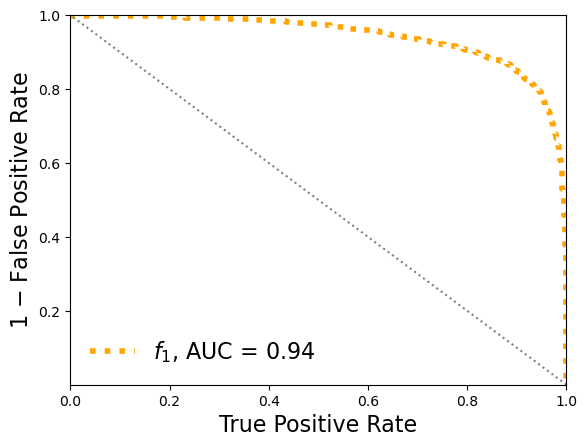

 
roc_auc_conv:  0.9414015370749502
############################### 

###############################
 TESTING: 
conv_layers_pS1 :  1
conv_layers_pS2 :  1
conv_layers_bot :  1
conv_layers_top :  2
learning_rate :  0.001
alpha_value :  0.05
batch_size :  128
 
Epoch 1/500


/home/andres/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 17s 409ms/step - loss: 1.1797 - accuracy: 0.5025 - val_loss: 0.8792 - val_accuracy: 0.5147
Epoch 2/500
40/40 [==============================] - 16s 402ms/step - loss: 0.8150 - accuracy: 0.5909 - val_loss: 0.6427 - val_accuracy: 0.8344
Epoch 3/500
40/40 [==============================] - 16s 401ms/step - loss: 0.6362 - accuracy: 0.7570 - val_loss: 0.5243 - val_accuracy: 0.8308
Epoch 4/500
40/40 [==============================] - 16s 400ms/step - loss: 0.5623 - accuracy: 0.8082 - val_loss: 0.4870 - val_accuracy: 0.8392
Epoch 5/500
40/40 [==============================] - 16s 400ms/step - loss: 0.5280 - accuracy: 0.8150 - val_loss: 0.4733 - val_accuracy: 0.8320
Epoch 6/500
40/40 [==============================] - 16s 400ms/step - loss: 0.5050 - accuracy: 0.8256 - val_loss: 0.4618 - val_accuracy: 0.8392
Epoch 7/500
40/40 [==============================] - 16s 401ms/step - loss: 0.4894 - accuracy: 0.8244 - val_loss: 0.4418 - val_accuracy: 0.8404
Epoc

40/40 [==============================] - 16s 406ms/step - loss: 0.3531 - accuracy: 0.8678 - val_loss: 0.3455 - val_accuracy: 0.8734
Epoch 114/500
40/40 [==============================] - 17s 416ms/step - loss: 0.3513 - accuracy: 0.8654 - val_loss: 0.3620 - val_accuracy: 0.8698
Epoch 115/500
40/40 [==============================] - 16s 403ms/step - loss: 0.3515 - accuracy: 0.8696 - val_loss: 0.3519 - val_accuracy: 0.8662
Epoch 116/500
40/40 [==============================] - 16s 400ms/step - loss: 0.3813 - accuracy: 0.8670 - val_loss: 0.3722 - val_accuracy: 0.8734
Epoch 117/500
40/40 [==============================] - 17s 417ms/step - loss: 0.3645 - accuracy: 0.8684 - val_loss: 0.3864 - val_accuracy: 0.8596
Epoch 118/500
22/40 [===============>..............] - ETA: 7s - loss: 0.3554 - accuracy: 0.8686

KeyboardInterrupt: 

In [22]:
conv_layers_pS1 = [1,2]
conv_layers_pS2 = [1,2]
conv_layers_bot = [1,2]
conv_layers_top = [1,2]

learning_rate = [0.005,0.001,0.01]
alpha_value = [0.001, 0.05, 0.01]

batch_size = [64,128,256]



tot_epochs = 500

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)


ev_count = 0

for i in range(len(conv_layers_pS1)):
    for j in range(len(conv_layers_pS2)):
        for k in range(len(conv_layers_bot)):
            for l in range(len(conv_layers_top)):
                for m in range(len(learning_rate)):
                    for n in range(len(alpha_value)):
                        for p in range(len(batch_size)):
                            
                            ev_count +=1
                            
                            if ev_count > 39:
                                
                                print('###############################')
                                print(' TESTING: ')
                                print('conv_layers_pS1 : ', conv_layers_pS1[i])
                                print('conv_layers_pS2 : ', conv_layers_pS2[j])
                                print('conv_layers_bot : ', conv_layers_bot[k])
                                print('conv_layers_top : ', conv_layers_top[l])
                                print('learning_rate : ', learning_rate[m])
                                print('alpha_value : ', alpha_value[n])
                                print('batch_size : ', batch_size[p])
                                print(' ')


                                model=create_model(conv_layers_pS1[i], conv_layers_pS2[j], conv_layers_bot[k], conv_layers_top[l], learning_rate[m], alpha_value[n])

                                history = model.fit([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train], 
                                              y_mon1_train, 
                                              batch_size=batch_size[p],
                                              epochs=tot_epochs,
                                              callbacks=[stop_training],
                                              verbose=1, 
                                              validation_data=([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val], y_mon1_val),
                                              shuffle=True)


                                # Plot de la cost function para la train y test data
                                plt.plot(history.history['loss'])
                                plt.plot(history.history['val_loss'])
                                plt.title('model loss')
                                plt.legend(['train', 'test'], loc='upper left')
                                plt.ylabel('loss')
                                plt.xlabel('epoch')
                                plt.show()

                                # Plot de la accuracy function para la train y test data
                                plt.figure()
                                plt.plot(history.history['accuracy'])
                                plt.plot(history.history['val_accuracy'])
                                plt.title('model accuracy')
                                plt.ylabel('accuracy')
                                plt.xlabel('epoch')
                                plt.legend(['train', 'test'], loc='upper left')
                                plt.show()




                                #model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
                                y_pred_conv = model.predict([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test])

                                # Compute ROC curve and ROC area for each class
                                fpr_conv = dict()
                                tpr_conv = dict()
                                roc_auc_conv = dict()
                                fpr_conv, tpr_conv, _ = roc_curve(y_mon1_test, y_pred_conv)
                                roc_auc_conv = auc(fpr_conv, tpr_conv)


                                plt.figure()
                                plt.plot(tpr_conv,1-fpr_conv,label="$f_{1}$, AUC = %0.2f" % roc_auc_conv,color="orange",ls=":",lw=4)
                                plt.plot([1,0],[0,1],ls=":",color="grey")
                                plt.xlabel("True Positive Rate",fontsize=16)
                                plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
                                plt.legend()
                                plt.xlim([0,1])
                                plt.ylim([0,1])
                                plt.yticks([0.2,0.4,0.6,0.8,1.])
                                plt.legend(frameon=False,fontsize=16)
                                plt.show()


                                with open('grid.dat', 'a') as file:
                                    file.write( "%0.4f %d %d %d %d %0.3f %0.3f %d\n" % (roc_auc_conv, conv_layers_pS1[i], conv_layers_pS2[j], conv_layers_bot[k], conv_layers_top[l], learning_rate[m], alpha_value[n], batch_size[p]) )


                                print(' ')
                                print('roc_auc_conv: ', roc_auc_conv)
                                print('############################### \n')

In [100]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',